In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Cambiar al directorio donde se encuentra el dataset
dataset_path = '/content/drive/My Drive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos'
os.listdir(dataset_path)  # Verifica los archivos en el directorio

Mounted at /content/drive


['readme.md',
 'Lexique - Data Analyst.xlsx',
 'extract - cash request - data analyst.csv',
 'extract - fees - data analyst - .csv',
 'extract - cash request - data analyst.gsheet',
 'extract - fees - data analyst - .gsheet',
 'payments_manager.py']

In [3]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
credit_requests = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
# Crear una copia del DataFrame para preservar el original
cr = credit_requests.copy()

# Cargar el dataset de tarifas o fees para análisis de cohortes de tarifas
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')
# Crear una copia del DataFrame para preservar el original
fs = fees.copy()

In [4]:
# Renombrar 'id' a 'cash_id' para mayor claridad (y para el merge posterior con fees)
cr.rename(columns={'id': 'cash_id'}, inplace=True)

In [5]:
# Ver NA en columna 'user_id'
cr[cr['user_id'].notna()].nunique() # 21867 válidos
cr[cr['user_id'].isna()].nunique() # 2103 Nan
# Comprobación: 21867 válidos + 2103 NaN = 23970 filas

# Comprobar que 'user_id' y 'deteled_account_id' son complementarios
cr[cr['user_id'].isna() & cr['deleted_account_id'].isna()] # Empty dataframe -> Siempre tenemos un valor válido en una de las dos columnas

# Comprobar solapamientos
cr[cr['user_id'].notna() & cr['deleted_account_id'].notna()] # La fila crid=280 tiene user_id=3161 y a la vez deleted_account_id=262

cash_id  amount      status                     created_at  \
7313      280   100.0  money_back  2019-12-21 16:01:38.756985+00   

                         updated_at  user_id            moderated_at  \
7313  2020-11-04 12:55:32.000656+00   3161.0  2019-12-22 13:48:26+00   

      deleted_account_id      reimbursement_date cash_request_received_date  \
7313               262.0  2020-01-16 23:00:00+00                 2019-12-24   

                    money_back_date transfer_type send_at recovery_status  \
7313  2020-11-23 10:31:54.598593+00       regular     NaN       completed   

                      reco_creation               reco_last_update  
7313  2020-03-20 14:12:53.160242+00  2020-03-31 16:05:16.427692+00

In [6]:
# Nueva columna 'id_completo' a partir de user_id + deleted_account_id
cr.loc[:, 'id_completo'] = cr['user_id'].combine_first(cr['deleted_account_id'])
# Conversión de float a int
cr['id_completo'] = cr['id_completo'].astype(int)

In [7]:
# Convertir 'created_at' a tipo datetime para manipulación de fechas
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr.head()

cash_id  amount    status                       created_at  \
0        5   100.0  rejected 2019-12-10 19:05:21.596873+00:00   
1       70   100.0  rejected 2019-12-10 19:50:12.347780+00:00   
2        7   100.0  rejected 2019-12-10 19:13:35.825460+00:00   
3       10    99.0  rejected 2019-12-10 19:16:10.880172+00:00   
4     1594   100.0  rejected 2020-05-06 09:59:38.877376+00:00   

                      updated_at  user_id                   moderated_at  \
0   2019-12-11 16:47:42.40783+00    804.0  2019-12-11 16:47:42.405646+00   
1  2019-12-11 14:24:22.900054+00    231.0  2019-12-11 14:24:22.897988+00   
2  2019-12-11 09:46:59.779773+00    191.0  2019-12-11 09:46:59.777728+00   
3  2019-12-18 14:26:18.136163+00    761.0  2019-12-18 14:26:18.128407+00   
4   2020-05-07 09:21:55.34008+00   7686.0  2020-05-07 09:21:55.320193+00   

   deleted_account_id             reimbursement_date  \
0                 NaN  2020-01-09 19:05:21.596363+00   
1                 NaN   2020-01-09 19:50:12.34778+00   
2                 NaN  2020-01-09 19:13:35.825041+00   
3                 NaN  2020-01-09 19:16:10.879606+00   
4                 NaN         2020-06-05 22:00:00+00   

  cash_request_received_date money_back_date transfer_type send_at  \
0                        NaN             NaN       regular     NaN   
1                        NaN             NaN       regular     NaN   
2                        NaN             NaN       regular     NaN   
3                        NaN             NaN       regular     NaN   
4                        NaN             NaN       regular     NaN   

  recovery_status reco_creation reco_last_update  id_completo  
0             NaN           NaN              NaN          804  
1             NaN           NaN              NaN          231  
2             NaN           NaN              NaN          191  
3             NaN           NaN              NaN          761  
4             NaN           NaN              NaN         7686

In [8]:
# Convertir la columna 'created_at' a una fecha sin zona horaria
cr['created_at'] = cr['created_at'].dt.tz_localize(None)
cr.head()

cash_id  amount    status                 created_at  \
0        5   100.0  rejected 2019-12-10 19:05:21.596873   
1       70   100.0  rejected 2019-12-10 19:50:12.347780   
2        7   100.0  rejected 2019-12-10 19:13:35.825460   
3       10    99.0  rejected 2019-12-10 19:16:10.880172   
4     1594   100.0  rejected 2020-05-06 09:59:38.877376   

                      updated_at  user_id                   moderated_at  \
0   2019-12-11 16:47:42.40783+00    804.0  2019-12-11 16:47:42.405646+00   
1  2019-12-11 14:24:22.900054+00    231.0  2019-12-11 14:24:22.897988+00   
2  2019-12-11 09:46:59.779773+00    191.0  2019-12-11 09:46:59.777728+00   
3  2019-12-18 14:26:18.136163+00    761.0  2019-12-18 14:26:18.128407+00   
4   2020-05-07 09:21:55.34008+00   7686.0  2020-05-07 09:21:55.320193+00   

   deleted_account_id             reimbursement_date  \
0                 NaN  2020-01-09 19:05:21.596363+00   
1                 NaN   2020-01-09 19:50:12.34778+00   
2                 NaN  2020-01-09 19:13:35.825041+00   
3                 NaN  2020-01-09 19:16:10.879606+00   
4                 NaN         2020-06-05 22:00:00+00   

  cash_request_received_date money_back_date transfer_type send_at  \
0                        NaN             NaN       regular     NaN   
1                        NaN             NaN       regular     NaN   
2                        NaN             NaN       regular     NaN   
3                        NaN             NaN       regular     NaN   
4                        NaN             NaN       regular     NaN   

  recovery_status reco_creation reco_last_update  id_completo  
0             NaN           NaN              NaN          804  
1             NaN           NaN              NaN          231  
2             NaN           NaN              NaN          191  
3             NaN           NaN              NaN          761  
4             NaN           NaN              NaN         7686

In [9]:
# Crear columna 'Mes' indicando el mes de cada solicitud
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr.head()

cash_id  amount    status                 created_at  \
0        5   100.0  rejected 2019-12-10 19:05:21.596873   
1       70   100.0  rejected 2019-12-10 19:50:12.347780   
2        7   100.0  rejected 2019-12-10 19:13:35.825460   
3       10    99.0  rejected 2019-12-10 19:16:10.880172   
4     1594   100.0  rejected 2020-05-06 09:59:38.877376   

                      updated_at  user_id                   moderated_at  \
0   2019-12-11 16:47:42.40783+00    804.0  2019-12-11 16:47:42.405646+00   
1  2019-12-11 14:24:22.900054+00    231.0  2019-12-11 14:24:22.897988+00   
2  2019-12-11 09:46:59.779773+00    191.0  2019-12-11 09:46:59.777728+00   
3  2019-12-18 14:26:18.136163+00    761.0  2019-12-18 14:26:18.128407+00   
4   2020-05-07 09:21:55.34008+00   7686.0  2020-05-07 09:21:55.320193+00   

   deleted_account_id             reimbursement_date  \
0                 NaN  2020-01-09 19:05:21.596363+00   
1                 NaN   2020-01-09 19:50:12.34778+00   
2                 NaN  2020-01-09 19:13:35.825041+00   
3                 NaN  2020-01-09 19:16:10.879606+00   
4                 NaN         2020-06-05 22:00:00+00   

  cash_request_received_date money_back_date transfer_type send_at  \
0                        NaN             NaN       regular     NaN   
1                        NaN             NaN       regular     NaN   
2                        NaN             NaN       regular     NaN   
3                        NaN             NaN       regular     NaN   
4                        NaN             NaN       regular     NaN   

  recovery_status reco_creation reco_last_update  id_completo      Mes  
0             NaN           NaN              NaN          804  2019-12  
1             NaN           NaN              NaN          231  2019-12  
2             NaN           NaN              NaN          191  2019-12  
3             NaN           NaN              NaN          761  2019-12  
4             NaN           NaN              NaN         7686  2020-05

In [10]:
# Crear nuevas columnas de tiempo a partir de 'created_at'
cr['Mes'] = cr['created_at'].dt.to_period('M')  # Mes (YYYY-MM)
cr['Semana'] = cr['created_at'].dt.to_period('W')  # Semana (YYYY-WW)
cr['Día'] = cr['created_at'].dt.to_period('D')  # Día (YYYY-MM-DD)
cr['Hora'] = cr['created_at'].dt.strftime('%H:%M:%S') # Hora del día

# Mostrar las primeras filas para verificar
cr.head()

cash_id  amount    status                 created_at  \
0        5   100.0  rejected 2019-12-10 19:05:21.596873   
1       70   100.0  rejected 2019-12-10 19:50:12.347780   
2        7   100.0  rejected 2019-12-10 19:13:35.825460   
3       10    99.0  rejected 2019-12-10 19:16:10.880172   
4     1594   100.0  rejected 2020-05-06 09:59:38.877376   

                      updated_at  user_id                   moderated_at  \
0   2019-12-11 16:47:42.40783+00    804.0  2019-12-11 16:47:42.405646+00   
1  2019-12-11 14:24:22.900054+00    231.0  2019-12-11 14:24:22.897988+00   
2  2019-12-11 09:46:59.779773+00    191.0  2019-12-11 09:46:59.777728+00   
3  2019-12-18 14:26:18.136163+00    761.0  2019-12-18 14:26:18.128407+00   
4   2020-05-07 09:21:55.34008+00   7686.0  2020-05-07 09:21:55.320193+00   

   deleted_account_id             reimbursement_date  \
0                 NaN  2020-01-09 19:05:21.596363+00   
1                 NaN   2020-01-09 19:50:12.34778+00   
2                 NaN  2020-01-09 19:13:35.825041+00   
3                 NaN  2020-01-09 19:16:10.879606+00   
4                 NaN         2020-06-05 22:00:00+00   

  cash_request_received_date  ... transfer_type send_at recovery_status  \
0                        NaN  ...       regular     NaN             NaN   
1                        NaN  ...       regular     NaN             NaN   
2                        NaN  ...       regular     NaN             NaN   
3                        NaN  ...       regular     NaN             NaN   
4                        NaN  ...       regular     NaN             NaN   

  reco_creation reco_last_update id_completo      Mes                 Semana  \
0           NaN              NaN         804  2019-12  2019-12-09/2019-12-15   
1           NaN              NaN         231  2019-12  2019-12-09/2019-12-15   
2           NaN              NaN         191  2019-12  2019-12-09/2019-12-15   
3           NaN              NaN         761  2019-12  2019-12-09/2019-12-15   
4           NaN              NaN        7686  2020-05  2020-05-04/2020-05-10   

          Día      Hora  
0  2019-12-10  19:05:21  
1  2019-12-10  19:50:12  
2  2019-12-10  19:13:35  
3  2019-12-10  19:16:10  
4  2020-05-06  09:59:38  

[5 rows x 21 columns]

In [11]:
# Crear columna 'Primera_Solicitud' que indica el mes de la primera solicitud de cada cliente
cr['Primera_Solicitud'] = cr.groupby('id_completo')['created_at'].transform('min').dt.to_period('M')
cr.head(10)

cash_id  amount      status                 created_at  \
0        5   100.0    rejected 2019-12-10 19:05:21.596873   
1       70   100.0    rejected 2019-12-10 19:50:12.347780   
2        7   100.0    rejected 2019-12-10 19:13:35.825460   
3       10    99.0    rejected 2019-12-10 19:16:10.880172   
4     1594   100.0    rejected 2020-05-06 09:59:38.877376   
5     2145   100.0  money_back 2020-05-23 20:58:55.129432   
6     3512   100.0    rejected 2020-06-16 17:07:38.452652   
7      654   100.0    rejected 2020-02-10 01:11:53.808270   
8     5672   100.0    canceled 2020-06-28 12:06:33.712840   
9       71    90.0    rejected 2019-12-10 19:51:23.911206   

                      updated_at  user_id                   moderated_at  \
0   2019-12-11 16:47:42.40783+00    804.0  2019-12-11 16:47:42.405646+00   
1  2019-12-11 14:24:22.900054+00    231.0  2019-12-11 14:24:22.897988+00   
2  2019-12-11 09:46:59.779773+00    191.0  2019-12-11 09:46:59.777728+00   
3  2019-12-18 14:26:18.136163+00    761.0  2019-12-18 14:26:18.128407+00   
4   2020-05-07 09:21:55.34008+00   7686.0  2020-05-07 09:21:55.320193+00   
5  2020-07-06 03:36:03.023911+00   9489.0   2020-05-24 12:40:33.05491+00   
6  2020-06-17 10:21:21.364746+00  14631.0  2020-06-17 10:21:21.360742+00   
7  2020-02-10 11:53:32.104131+00      NaN  2020-02-10 09:11:21.350695+00   
8  2020-06-28 12:06:33.712853+00      NaN                            NaN   
9  2019-12-12 15:06:11.192888+00    897.0  2019-12-12 15:06:11.190299+00   

   deleted_account_id             reimbursement_date  \
0                 NaN  2020-01-09 19:05:21.596363+00   
1                 NaN   2020-01-09 19:50:12.34778+00   
2                 NaN  2020-01-09 19:13:35.825041+00   
3                 NaN  2020-01-09 19:16:10.879606+00   
4                 NaN         2020-06-05 22:00:00+00   
5                 NaN         2020-06-06 22:00:00+00   
6                 NaN         2020-07-11 23:51:00+00   
7               309.0   2020-03-11 01:11:53.80793+00   
8              2499.0         2020-07-07 22:00:00+00   
9                 NaN  2019-12-17 19:51:23.910748+00   

  cash_request_received_date  ... send_at recovery_status  \
0                        NaN  ...     NaN             NaN   
1                        NaN  ...     NaN             NaN   
2                        NaN  ...     NaN             NaN   
3                        NaN  ...     NaN             NaN   
4                        NaN  ...     NaN             NaN   
5                 2020-05-26  ...     NaN       completed   
6                        NaN  ...     NaN             NaN   
7                        NaN  ...     NaN             NaN   
8                        NaN  ...     NaN             NaN   
9                        NaN  ...     NaN             NaN   

                   reco_creation               reco_last_update id_completo  \
0                            NaN                            NaN         804   
1                            NaN                            NaN         231   
2                            NaN                            NaN         191   
3                            NaN                            NaN         761   
4                            NaN                            NaN        7686   
5  2020-06-12 22:27:04.837525+00  2020-07-06 03:36:03.030904+00        9489   
6                            NaN                            NaN       14631   
7                            NaN                            NaN         309   
8                            NaN                            NaN        2499   
9                            NaN                            NaN         897   

       Mes                 Semana         Día      Hora Primera_Solicitud  
0  2019-12  2019-12-09/2019-12-15  2019-12-10  19:05:21           2019-12  
1  2019-12  2019-12-09/2019-12-15  2019-12-10  19:50:12           2019-12  
2  2019-12  2019-12-09/2019-12-15  2019-12-10  19:13:35           2019-12  
3  2019-12  2019-12-09/2019-12-

In [12]:
grouped1st = cr.pivot_table(
    values = "created_at",
    index = "id_completo",
    aggfunc = "min"
)
warnings.filterwarnings('ignore', category=UserWarning)
grouped1st['Primera_Solicitud'] = grouped1st['created_at'].dt.to_period('M')
warnings.resetwarnings()
grouped1st.head()

created_at Primera_Solicitud
id_completo                                             
34          2020-04-20 15:50:21.187257           2020-04
35          2019-12-13 20:27:38.106778           2019-12
47          2019-11-19 13:57:53.511561           2019-11
52          2019-12-17 09:01:12.584634           2019-12
53          2019-12-21 11:39:03.844436           2019-12

# PRIMER COHORTE (nivel de usuario)

Solo usuarios actuales

In [13]:
# Definir los bins y las etiquetas para los segmentos de gasto
bins = [cr['amount'].min(), 50, 150, cr['amount'].max()]
labels = ['Low', 'Medium', 'High']

# Asignar cada usuario a un segmento de gasto
cr['spend_segment'] = pd.cut(cr['amount'], bins=bins, labels=labels, include_lowest=True)

# Crear diccionario para almacenar los user_id por segmento
grouped_users = {
    'Low': cr.loc[cr['spend_segment'] == 'Low', 'user_id'].tolist(),
    'Medium': cr.loc[cr['spend_segment'] == 'Medium', 'user_id'].tolist(),
    'High': cr.loc[cr['spend_segment'] == 'High', 'user_id'].tolist()
}

# Mostrar los resultados
print(grouped_users)

{'Low': [2908.0, 163.0, 2460.0, nan, 21465.0, 23318.0, 115.0, 38075.0, 2575.0, 3131.0, 1628.0, 1003.0, 792.0, 1601.0, nan, 1773.0, 1628.0, 2481.0, nan, 10560.0, 3558.0, 6812.0, 1861.0, nan, nan, 1393.0, 3109.0, 5620.0, nan, 2481.0, 18155.0, 7318.0, 8638.0, 36166.0, 4685.0, 860.0, 5594.0, 597.0, 8564.0, 8157.0, 1895.0, 6792.0, nan, 8040.0, 10203.0, 7780.0, 3377.0, 10516.0, 97141.0, 8857.0, 6461.0, 5496.0, 3849.0, 8456.0, 6345.0, 1022.0, 8674.0, 3377.0, 6511.0, 8720.0, 8638.0, 27816.0, nan, 9953.0, nan, 6929.0, 3377.0, 8873.0, nan, 9308.0, 31320.0, 7903.0, 26854.0, 4508.0, 1159.0, 6162.0, 5284.0, 10208.0, 8986.0, 1776.0, 36013.0, 6931.0, 2274.0, 38553.0, 8831.0, 8787.0, 9442.0, 8412.0, 86577.0, 30482.0, 8707.0, 4916.0, 6879.0, 860.0, 47.0, 8908.0, 9843.0, 16874.0, 14912.0, 8541.0, 9973.0, 2102.0, nan, 29684.0, nan, 4868.0, 8700.0, 22261.0, 38153.0, nan, 30872.0, 20598.0, 25850.0, 25169.0, 17519.0, 10086.0, 10414.0, nan, 14249.0, 6179.0, 20583.0, 15000.0, 13655.0, 2142.0, 12150.0, 13049.0

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importli

Solo usuarios eliminados

In [14]:
# Definir los bins y las etiquetas para los segmentos de gasto
bins = [cr['amount'].min(), 50, 150, cr['amount'].max()]
labels = ['Low', 'Medium', 'High']

# Asignar cada usuario a un segmento de gasto
cr['spend_segment'] = pd.cut(cr['amount'], bins=bins, labels=labels, include_lowest=True)

# Crear diccionario para almacenar los deleted_account_id por segmento
grouped_users = {
    'Low': cr.loc[cr['spend_segment'] == 'Low', 'deleted_account_id'].tolist(),
    'Medium': cr.loc[cr['spend_segment'] == 'Medium', 'deleted_account_id'].tolist(),
    'High': cr.loc[cr['spend_segment'] == 'High', 'deleted_account_id'].tolist()
}

# Mostrar los resultados
print(grouped_users)

{'Low': [nan, nan, nan, 302.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 30317.0, nan, nan, nan, 486.0, nan, nan, nan, nan, 1047.0, 486.0, nan, nan, nan, 486.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1264.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1310.0, nan, 1310.0, nan, nan, nan, 1310.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1310.0, nan, 3780.0, nan, nan, nan, nan, 2128.0, nan, nan, nan, nan, nan, nan, nan, 1672.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 3750.0, nan, nan, nan, nan, nan, nan, 2534.0, nan, nan, nan, nan, 2128.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 5543.0, nan, nan, nan, nan, nan, nan, 2037.

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Combinacion

In [15]:
# Definir los bins y las etiquetas para los segmentos de gasto
bins = [cr['amount'].min(), 50, 150, cr['amount'].max()]
labels = ['Low', 'Medium', 'High']

# Asignar cada usuario a un segmento de gasto
cr['spend_segment'] = pd.cut(cr['amount'], bins=bins, labels=labels, include_lowest=True)

# Crear diccionario para almacenar los id_completo por segmento
grouped_users = {
    'Low': cr.loc[cr['spend_segment'] == 'Low', 'id_completo'].tolist(),
    'Medium': cr.loc[cr['spend_segment'] == 'Medium', 'id_completo'].tolist(),
    'High': cr.loc[cr['spend_segment'] == 'High', 'id_completo'].tolist()
}

# Mostrar los resultados
print(grouped_users)

{'Low': [2908, 163, 2460, 302, 21465, 23318, 115, 38075, 2575, 3131, 1628, 1003, 792, 1601, 30317, 1773, 1628, 2481, 486, 10560, 3558, 6812, 1861, 1047, 486, 1393, 3109, 5620, 486, 2481, 18155, 7318, 8638, 36166, 4685, 860, 5594, 597, 8564, 8157, 1895, 6792, 1264, 8040, 10203, 7780, 3377, 10516, 97141, 8857, 6461, 5496, 3849, 8456, 6345, 1022, 8674, 3377, 6511, 8720, 8638, 27816, 1310, 9953, 1310, 6929, 3377, 8873, 1310, 9308, 31320, 7903, 26854, 4508, 1159, 6162, 5284, 10208, 8986, 1776, 36013, 6931, 2274, 38553, 8831, 8787, 9442, 8412, 86577, 30482, 8707, 4916, 6879, 860, 47, 8908, 9843, 16874, 14912, 8541, 9973, 2102, 1310, 29684, 3780, 4868, 8700, 22261, 38153, 2128, 30872, 20598, 25850, 25169, 17519, 10086, 10414, 1672, 14249, 6179, 20583, 15000, 13655, 2142, 12150, 13049, 11247, 10123, 10370, 8809, 4626, 2838, 52, 2102, 21476, 3750, 12159, 22501, 11294, 22783, 10130, 31231, 2534, 21876, 26268, 23542, 3377, 2128, 15020, 36069, 33200, 9748, 6976, 34591, 14158, 29077, 18467, 30022, 

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
cr.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cash_id  amount    status                 created_at  \
0        5   100.0  rejected 2019-12-10 19:05:21.596873   
1       70   100.0  rejected 2019-12-10 19:50:12.347780   
2        7   100.0  rejected 2019-12-10 19:13:35.825460   
3       10    99.0  rejected 2019-12-10 19:16:10.880172   
4     1594   100.0  rejected 2020-05-06 09:59:38.877376   

                      updated_at  user_id                   moderated_at  \
0   2019-12-11 16:47:42.40783+00    804.0  2019-12-11 16:47:42.405646+00   
1  2019-12-11 14:24:22.900054+00    231.0  2019-12-11 14:24:22.897988+00   
2  2019-12-11 09:46:59.779773+00    191.0  2019-12-11 09:46:59.777728+00   
3  2019-12-18 14:26:18.136163+00    761.0  2019-12-18 14:26:18.128407+00   
4   2020-05-07 09:21:55.34008+00   7686.0  2020-05-07 09:21:55.320193+00   

   deleted_account_id             reimbursement_date  \
0                 NaN  2020-01-09 19:05:21.596363+00   
1                 NaN   2020-01-09 19:50:12.34778+00   
2                 NaN  2020-01-09 19:13:35.825041+00   
3                 NaN  2020-01-09 19:16:10.879606+00   
4                 NaN         2020-06-05 22:00:00+00   

  cash_request_received_date  ... recovery_status reco_creation  \
0                        NaN  ...             NaN           NaN   
1                        NaN  ...             NaN           NaN   
2                        NaN  ...             NaN           NaN   
3                        NaN  ...             NaN           NaN   
4                        NaN  ...             NaN           NaN   

  reco_last_update id_completo      Mes                 Semana         Día  \
0              NaN         804  2019-12  2019-12-09/2019-12-15  2019-12-10   
1              NaN         231  2019-12  2019-12-09/2019-12-15  2019-12-10   
2              NaN         191  2019-12  2019-12-09/2019-12-15  2019-12-10   
3              NaN         761  2019-12  2019-12-09/2019-12-15  2019-12-10   
4              NaN        7686  2020-05  2020-05-04/2020-05-10  2020-05-06   

       Hora Primera_Solicitud spend_segment  
0  19:05:21           2019-12        Medium  
1  19:50:12           2019-12        Medium  
2  19:13:35           2019-12        Medium  
3  19:16:10           2019-12        Medium  
4  09:59:38           2020-05        Medium  

[5 rows x 23 columns]

In [17]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cash_id                     23970 non-null  int64         
 1   amount                      23970 non-null  float64       
 2   status                      23970 non-null  object        
 3   created_at                  23970 non-null  datetime64[ns]
 4   updated_at                  23970 non-null  object        
 5   user_id                     21867 non-null  float64       
 6   moderated_at                16035 non-null  object        
 7   deleted_account_id          2104 non-null   float64       
 8   reimbursement_date          23970 non-null  object        
 9   cash_request_received_date  16289 non-null  object        
 10  money_back_date             16543 non-null  object        
 11  transfer_type               23970 non-null  object    

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# FALTA ACTUALIZAR

In [ ]:
# FALTA ACTUALIZAR
grouped_users['Low']

## Valores Faltantes por segmentos

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


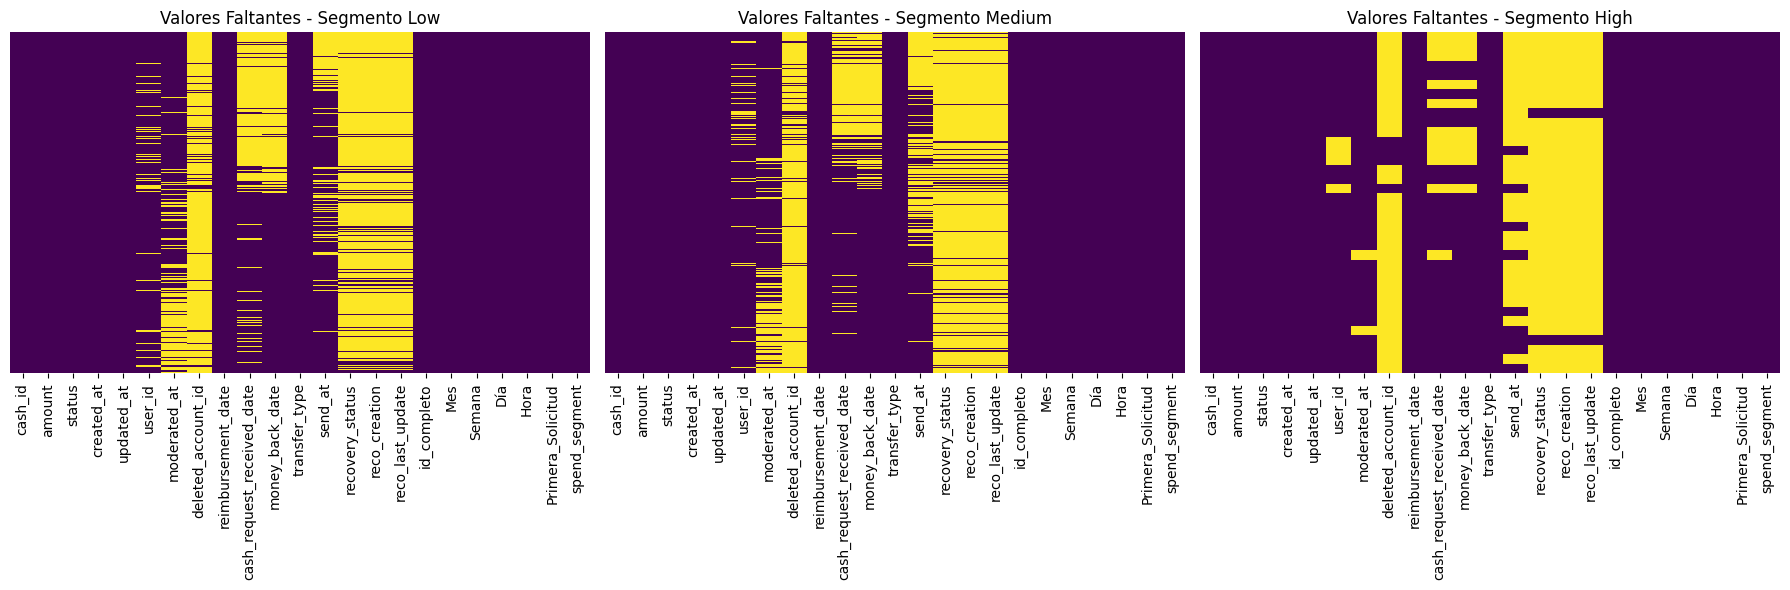

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear DataFrames por segmento a partir del diccionario grouped_users
low_users_df = cr[cr['id_completo'].isin(grouped_users['Low'])]
medium_users_df = cr[cr['id_completo'].isin(grouped_users['Medium'])]
high_users_df = cr[cr['id_completo'].isin(grouped_users['High'])]

# Configuración del tamaño de las figuras
plt.figure(figsize=(18, 6))

# Mapa de calor para segmento Low
plt.subplot(1, 3, 1)
sns.heatmap(low_users_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Valores Faltantes - Segmento Low')

# Mapa de calor para segmento Medium
plt.subplot(1, 3, 2)
sns.heatmap(medium_users_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Valores Faltantes - Segmento Medium')

# Mapa de calor para segmento High
plt.subplot(1, 3, 3)
sns.heatmap(high_users_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Valores Faltantes - Segmento High')

# Mostrar gráficos
plt.tight_layout()
plt.show()

## Histogramas

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importli

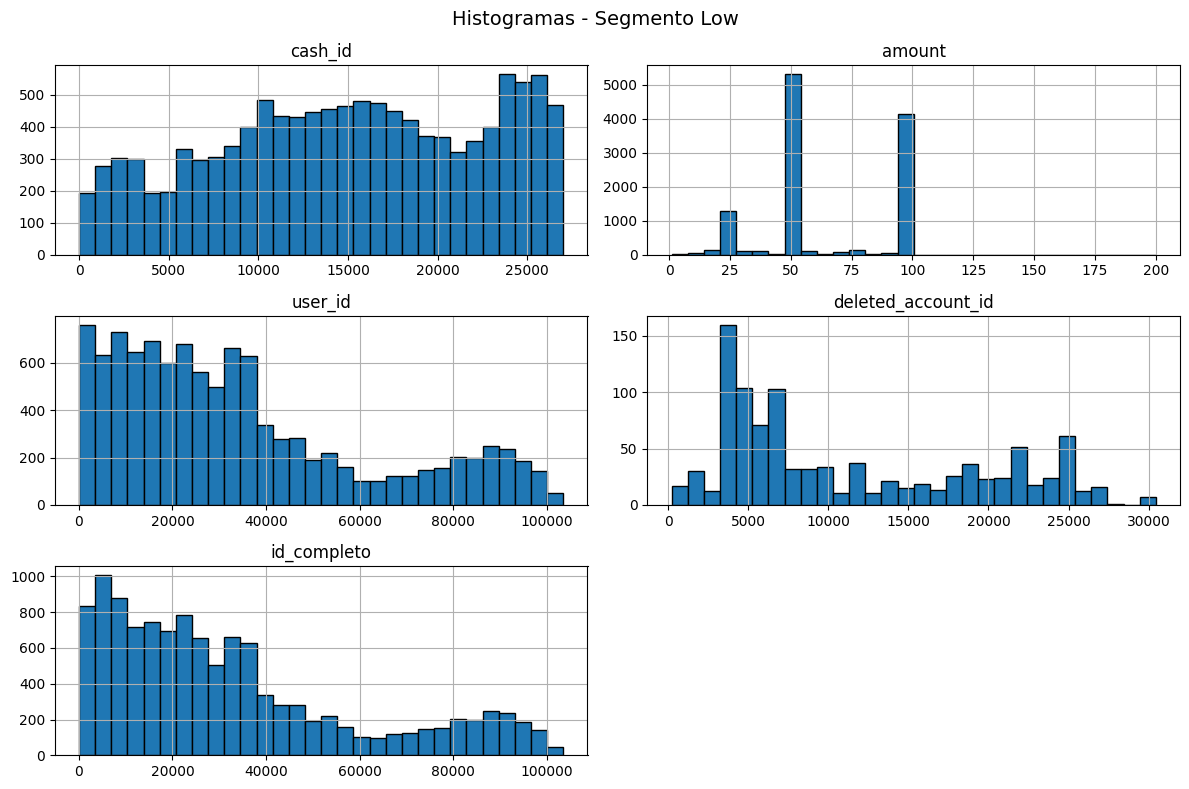

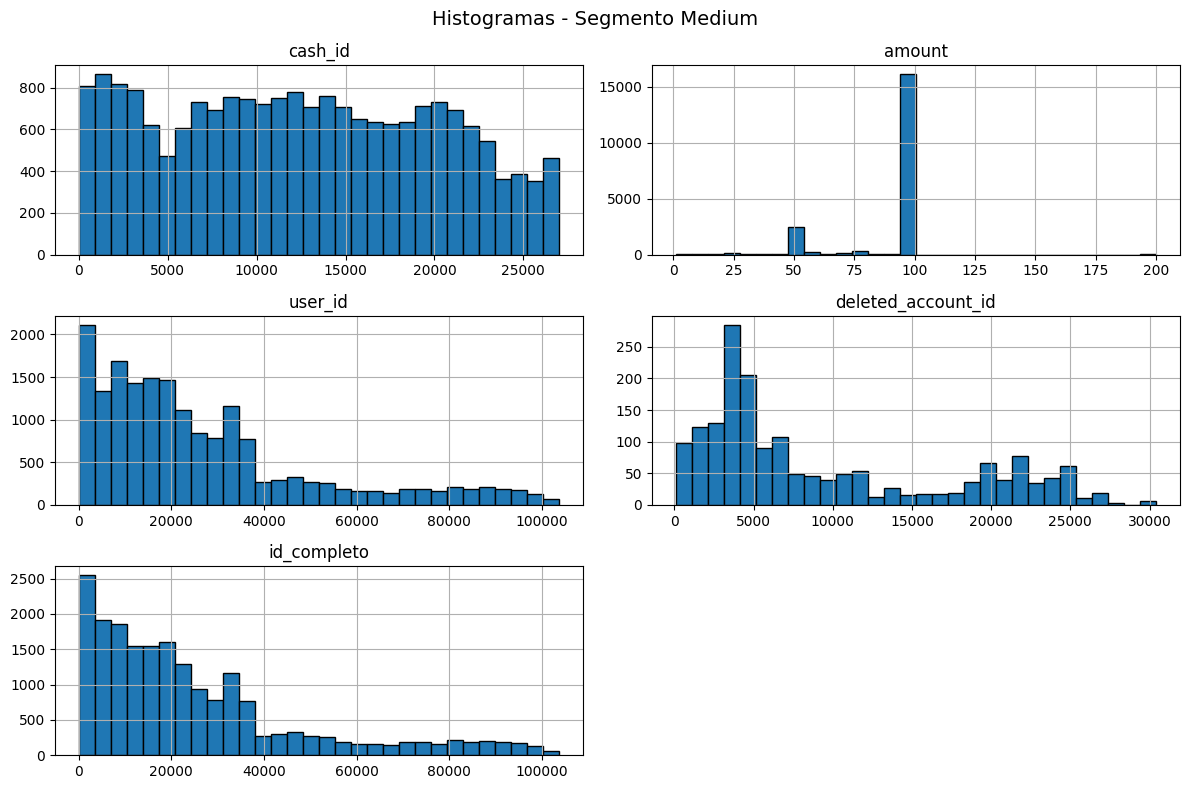

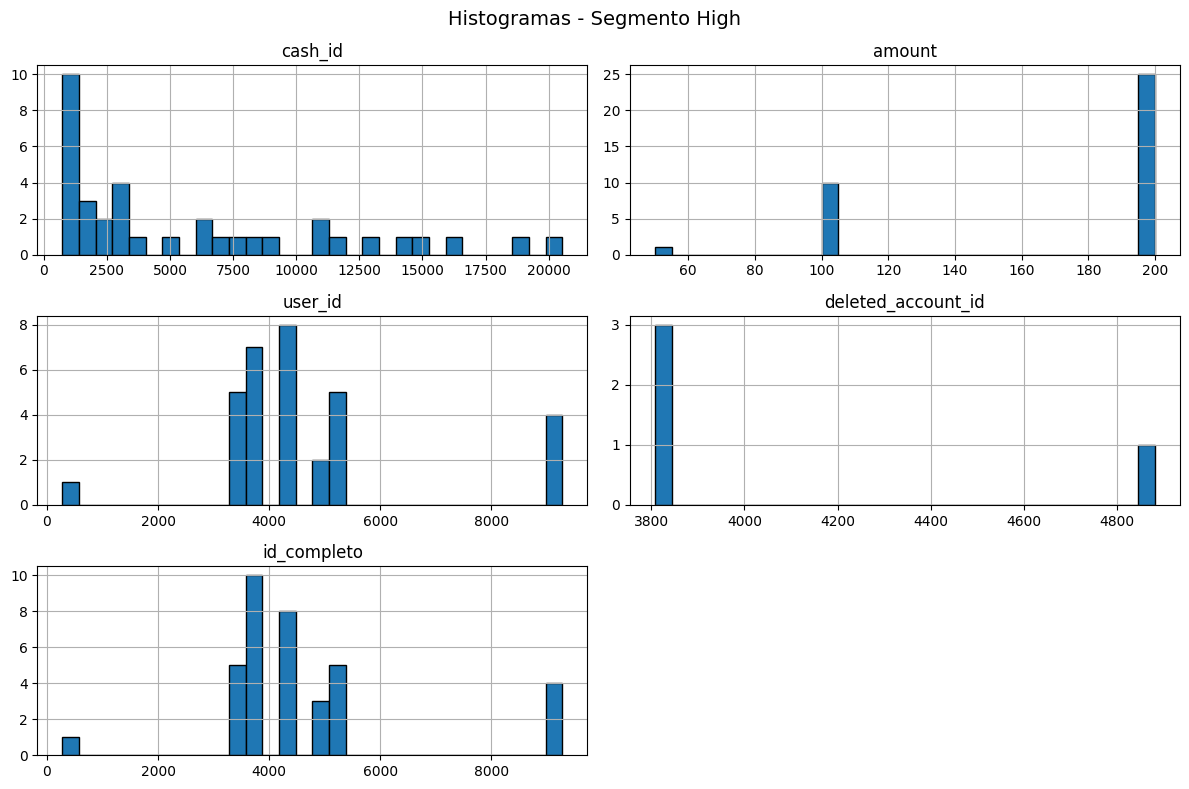

In [20]:
import matplotlib.pyplot as plt

# Función para graficar histogramas de columnas numéricas
def graficar_histogramas(df, titulo):
    columnas_numericas = df.select_dtypes(include=['number']).columns
    df[columnas_numericas].hist(figsize=(12, 8), bins=30, edgecolor='black')
    plt.suptitle(titulo, fontsize=14)
    plt.tight_layout()
    plt.show()

# Crear DataFrames filtrando por segmento
low_users_df = cr[cr['id_completo'].isin(grouped_users['Low'])]
medium_users_df = cr[cr['id_completo'].isin(grouped_users['Medium'])]
high_users_df = cr[cr['id_completo'].isin(grouped_users['High'])]

# Generar histogramas para cada segmento
graficar_histogramas(low_users_df, 'Histogramas - Segmento Low')
graficar_histogramas(medium_users_df, 'Histogramas - Segmento Medium')
graficar_histogramas(high_users_df, 'Histogramas - Segmento High')


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importli

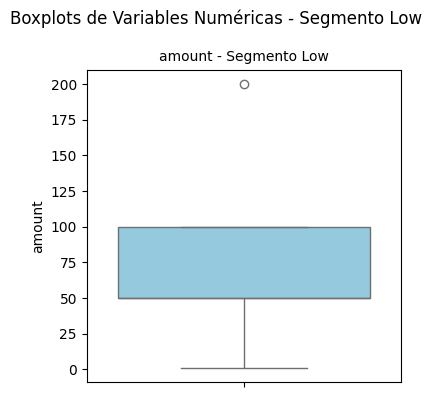

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


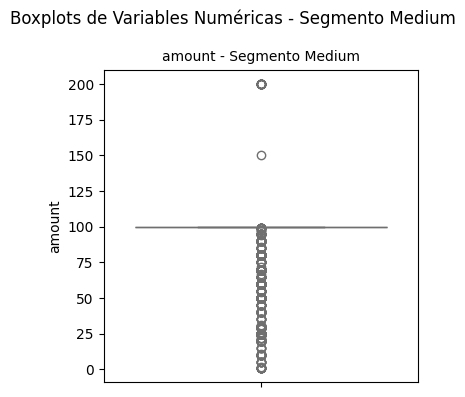

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


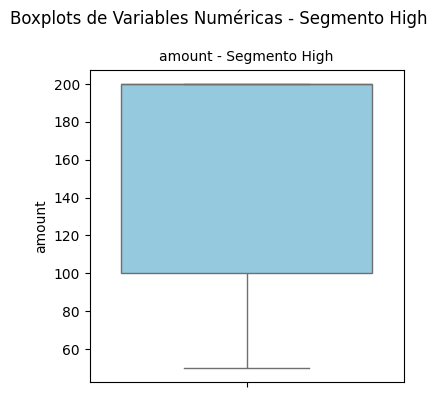

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def graficar_boxplots(df, titulo, max_cols=3):
    # Seleccionar columnas numéricas relevantes (excluyendo IDs)
    columnas_numericas = [col for col in df.select_dtypes(include=['number']).columns
                          if 'id' not in col.lower()]

    if not columnas_numericas:
        print(f"No hay columnas numéricas relevantes en {titulo}")
        return

    num_vars = len(columnas_numericas)
    num_cols = min(num_vars, max_cols)  # Determinar número de columnas
    num_rows = int(np.ceil(num_vars / num_cols))  # Determinar número de filas

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
    axes = np.array(axes).reshape(-1)  # Convertir a 1D para iterar

    for i, columna in enumerate(columnas_numericas):
        sns.boxplot(y=df[columna], ax=axes[i], color='skyblue')
        axes[i].set_title(f'{columna} - {titulo}', fontsize=10)

    # Ocultar gráficos vacíos si hay menos variables de las esperadas
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Boxplots de Variables Numéricas - {titulo}', fontsize=12)
    plt.tight_layout()
    plt.show()

# Filtrar datos por categorías en grouped_users
# Changed 'df' to 'cr' here to correctly filter the DataFrame
low_users_df = cr[cr['id_completo'].isin(grouped_users['Low'])]
medium_users_df = cr[cr['id_completo'].isin(grouped_users['Medium'])]
high_users_df = cr[cr['id_completo'].isin(grouped_users['High'])]

# Generar gráficos de boxplot para cada segmento
graficar_boxplots(low_users_df, 'Segmento Low')
graficar_boxplots(medium_users_df, 'Segmento Medium')
graficar_boxplots(high_users_df, 'Segmento High')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


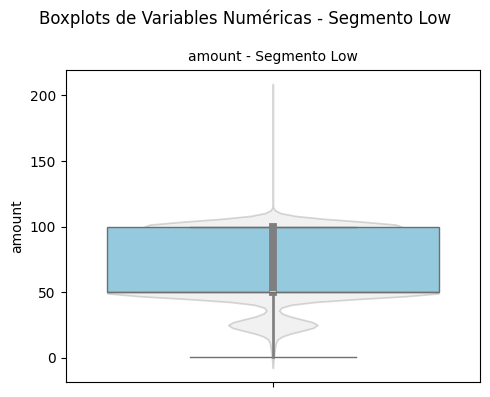

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


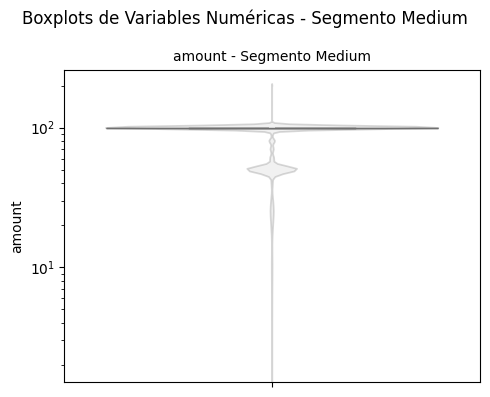

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


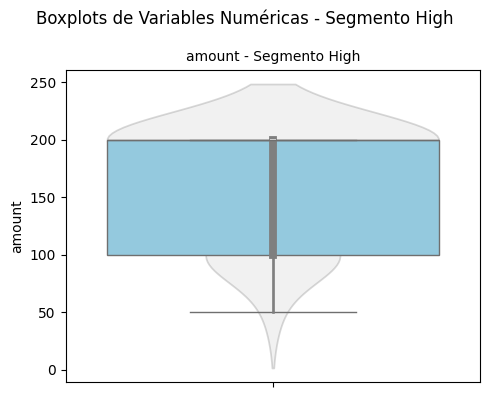

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def graficar_boxplots(df, titulo, max_cols=3, show_outliers=False, log_scale=False):
    # Seleccionar columnas numéricas relevantes (excluyendo IDs)
    columnas_numericas = [col for col in df.select_dtypes(include=['number']).columns
                          if 'id' not in col.lower()]

    if not columnas_numericas:
        print(f"No hay columnas numéricas relevantes en {titulo}")
        return

    num_vars = len(columnas_numericas)
    num_cols = min(num_vars, max_cols)  # Determinar número de columnas
    num_rows = int(np.ceil(num_vars / num_cols))  # Determinar número de filas

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))
    axes = np.array(axes).reshape(-1)  # Convertir a 1D para iterar

    for i, columna in enumerate(columnas_numericas):
        if df[columna].isna().all():
            print(f"La columna {columna} en {titulo} solo tiene valores NaN.")
            axes[i].axis('off')
            continue

        # Graficar Boxplot con opción para mostrar/ocultar outliers
        sns.boxplot(y=df[columna], ax=axes[i], color='skyblue', showfliers=show_outliers)

        # Opcional: Agregar gráfico de violín para mejor visualización de la distribución
        sns.violinplot(y=df[columna], ax=axes[i], color='lightgray', alpha=0.3)

        axes[i].set_title(f'{columna} - {titulo}', fontsize=10)

        # Aplicar escala logarítmica si es necesario
        if log_scale:
            axes[i].set_yscale('log')

    # Ocultar gráficos vacíos si hay menos variables de las esperadas
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Boxplots de Variables Numéricas - {titulo}', fontsize=12)
    plt.tight_layout()
    plt.show()

# Filtrar datos por categorías en grouped_users
low_users_df = cr[cr['id_completo'].isin(grouped_users['Low'])]
medium_users_df = cr[cr['id_completo'].isin(grouped_users['Medium'])]
high_users_df = cr[cr['id_completo'].isin(grouped_users['High'])]

# Generar gráficos de boxplot para cada segmento
graficar_boxplots(low_users_df, 'Segmento Low')
graficar_boxplots(medium_users_df, 'Segmento Medium', show_outliers=False, log_scale=True)  # Configuración mejorada para Medium
graficar_boxplots(high_users_df, 'Segmento High')


## Graficos de violin

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


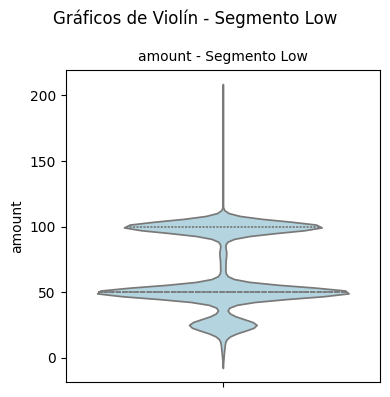

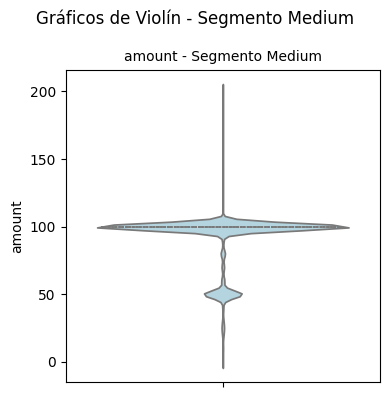

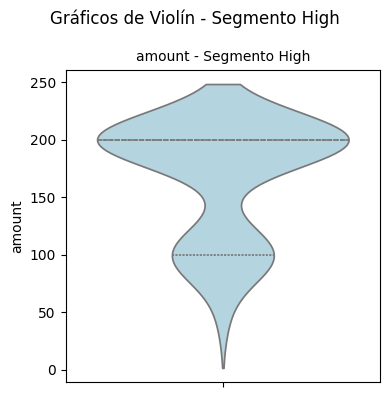

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Función para graficar violin plots de variables numéricas (excluyendo IDs)
def graficar_violin_plots(df, titulo, max_cols=3):
    # Seleccionar columnas numéricas relevantes (excluyendo IDs)
    columnas_numericas = [col for col in df.select_dtypes(include=['number']).columns
                          if 'id' not in col.lower()]

    if not columnas_numericas:
        print(f"No hay columnas numéricas relevantes en {titulo}")
        return

    num_vars = len(columnas_numericas)
    num_cols = min(num_vars, max_cols)  # Determinar número de columnas
    num_rows = int(np.ceil(num_vars / num_cols))  # Determinar número de filas

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
    axes = np.array(axes).reshape(-1)  # Convertir a 1D para iterar

    for i, columna in enumerate(columnas_numericas):
        sns.violinplot(y=df[columna], ax=axes[i], color='lightblue', inner='quartile')
        axes[i].set_title(f'{columna} - {titulo}', fontsize=10)

    # Ocultar gráficos vacíos si hay menos variables de las esperadas
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Gráficos de Violín - {titulo}', fontsize=12)
    plt.tight_layout()
    plt.show()

# Crear DataFrames filtrando por segmento
low_users_df = cr[cr['id_completo'].isin(grouped_users['Low'])]
medium_users_df = cr[cr['id_completo'].isin(grouped_users['Medium'])]
high_users_df = cr[cr['id_completo'].isin(grouped_users['High'])]

# Generar gráficos de violín para cada segmento
graficar_violin_plots(low_users_df, 'Segmento Low')
graficar_violin_plots(medium_users_df, 'Segmento Medium')
graficar_violin_plots(high_users_df, 'Segmento High')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


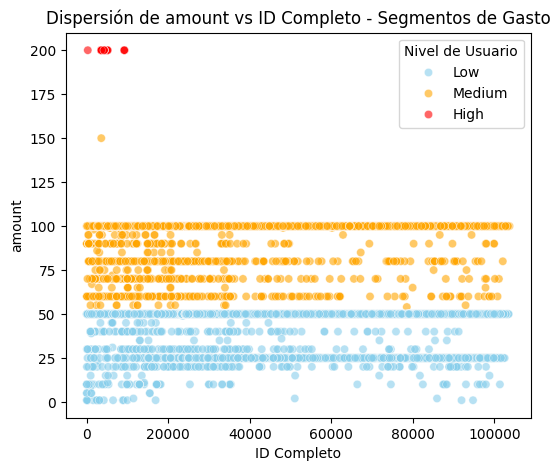

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Seleccionar variables numéricas relevantes (excluyendo IDs)
variables_relevantes = [col for col in cr.select_dtypes(include=['number']).columns if 'id' not in col.lower()]

# Asignar colores a los segmentos
colores_segmentos = {'Low': 'skyblue', 'Medium': 'orange', 'High': 'red'}

# Generar gráficos de dispersión para cada variable numérica
for columna in variables_relevantes:
    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=cr, x="id_completo", y=columna, hue="spend_segment", palette=colores_segmentos, alpha=0.6)
    plt.title(f"Dispersión de {columna} vs ID Completo - Segmentos de Gasto")
    plt.xlabel("ID Completo")
    plt.ylabel(columna)
    plt.legend(title="Nivel de Usuario")
    plt.show()


In [25]:
merged_df = cr.merge(fs, left_on='cash_id', right_on='cash_request_id', how='left')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cash_id                     32094 non-null  int64         
 1   amount                      32094 non-null  float64       
 2   status_x                    32094 non-null  object        
 3   created_at_x                32094 non-null  datetime64[ns]
 4   updated_at_x                32094 non-null  object        
 5   user_id                     29522 non-null  float64       
 6   moderated_at                21759 non-null  object        
 7   deleted_account_id          2573 non-null   float64       
 8   reimbursement_date          32094 non-null  object        
 9   cash_request_received_date  24149 non-null  object        
 10  money_back_date             23917 non-null  object        
 11  transfer_type               32094 non-null  object    

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


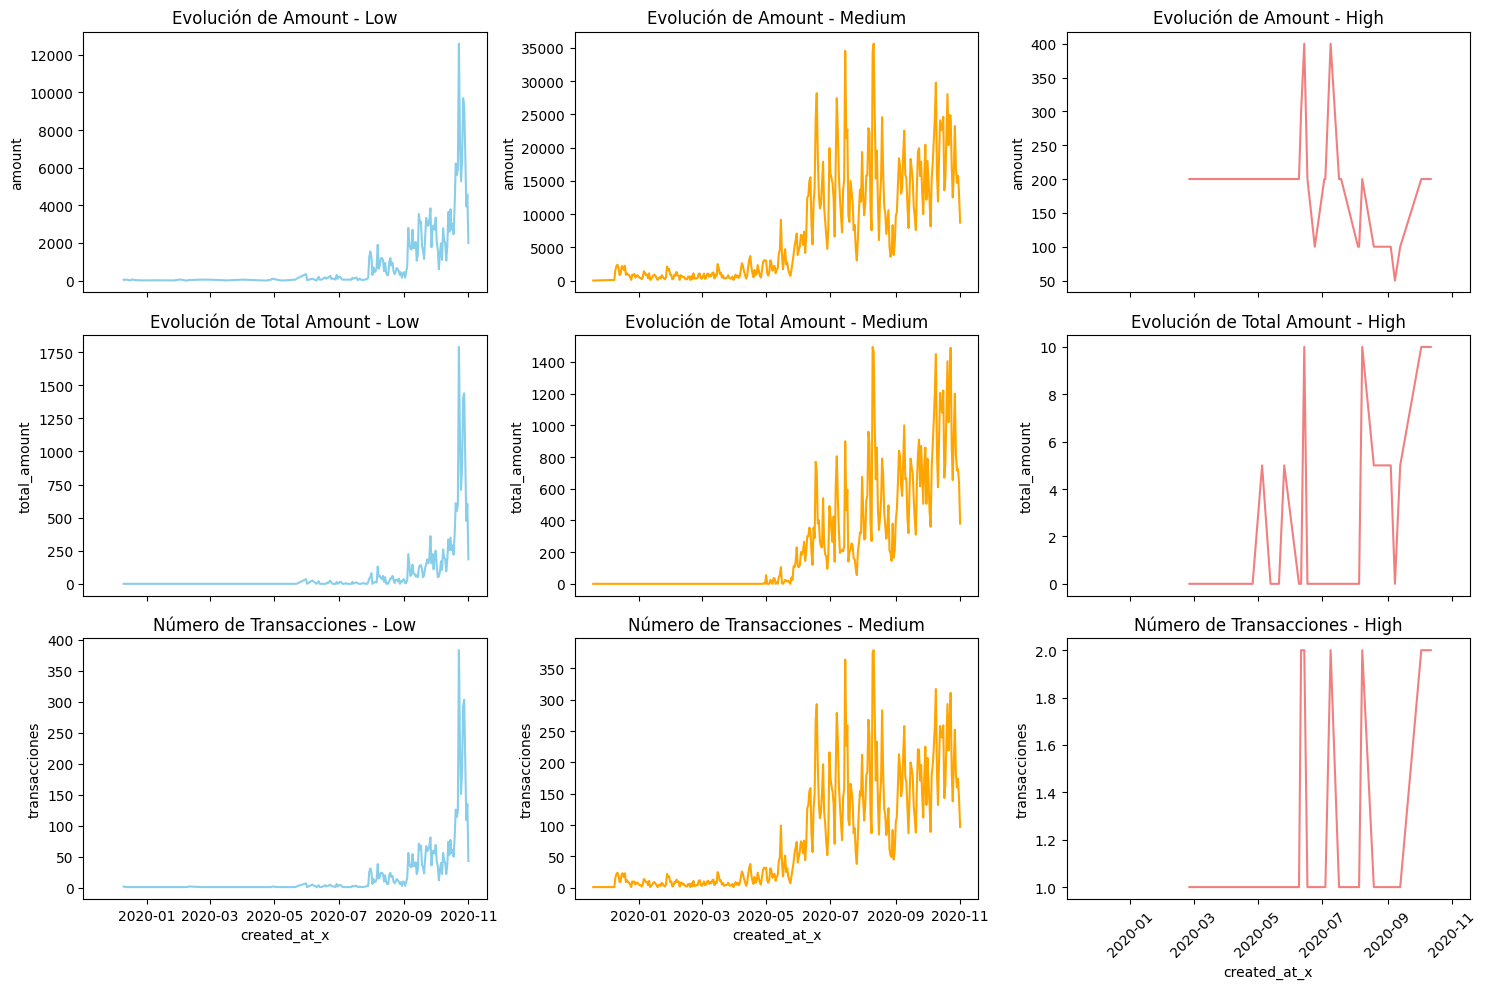

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir la columna de fecha a formato datetime
merged_df["created_at_x"] = pd.to_datetime(merged_df["created_at_x"], errors="coerce")

# Agregar la columna 'segmento' basada en grouped_users
merged_df["segmento"] = merged_df["id_completo"].map({user_id: segment for segment, user_ids in grouped_users.items() for user_id in user_ids})

# Filtrar datos por segmento
low_users_df = merged_df[merged_df["segmento"] == "Low"]
medium_users_df = merged_df[merged_df["segmento"] == "Medium"]
high_users_df = merged_df[merged_df["segmento"] == "High"]

# Función para procesar datos por segmento
def procesar_series_temporales(df):
    return df.groupby(df["created_at_x"].dt.date).agg({
        "amount": "sum",
        "total_amount": "sum",
        "id_completo": "count"  # Cantidad de transacciones por día
    }).rename(columns={"id_completo": "transacciones"})

# Obtener series temporales por segmento
low_ts = procesar_series_temporales(low_users_df)
medium_ts = procesar_series_temporales(medium_users_df)
high_ts = procesar_series_temporales(high_users_df)

# Configuración de gráficos
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

# Asignar colores a los segmentos
colores_segmentos = {"Low": "skyblue", "Medium": "orange", "High": "lightcoral"}

# Graficar series temporales para cada métrica y segmento
segmentos_ts = {"Low": low_ts, "Medium": medium_ts, "High": high_ts}
segmentos_nombres = list(segmentos_ts.keys())

for i, (segmento, df_ts) in enumerate(segmentos_ts.items()):
    sns.lineplot(ax=axes[0, i], x=df_ts.index, y=df_ts["amount"], color=colores_segmentos[segmento])
    axes[0, i].set_title(f"Evolución de Amount - {segmento}")

    sns.lineplot(ax=axes[1, i], x=df_ts.index, y=df_ts["total_amount"], color=colores_segmentos[segmento])
    axes[1, i].set_title(f"Evolución de Total Amount - {segmento}")

    sns.lineplot(ax=axes[2, i], x=df_ts.index, y=df_ts["transacciones"], color=colores_segmentos[segmento])
    axes[2, i].set_title(f"Número de Transacciones - {segmento}")

# Ajustes finales
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-28-73dd9ea2d96e>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[i], x=data.index.astype(str), y=data.values, palette=colores_segmentos[segmento])
<ipython-input-28-73dd9ea2d96e>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[i], x=data.index.astype(str), y=data.values, palette=colores_segmentos[segmento])

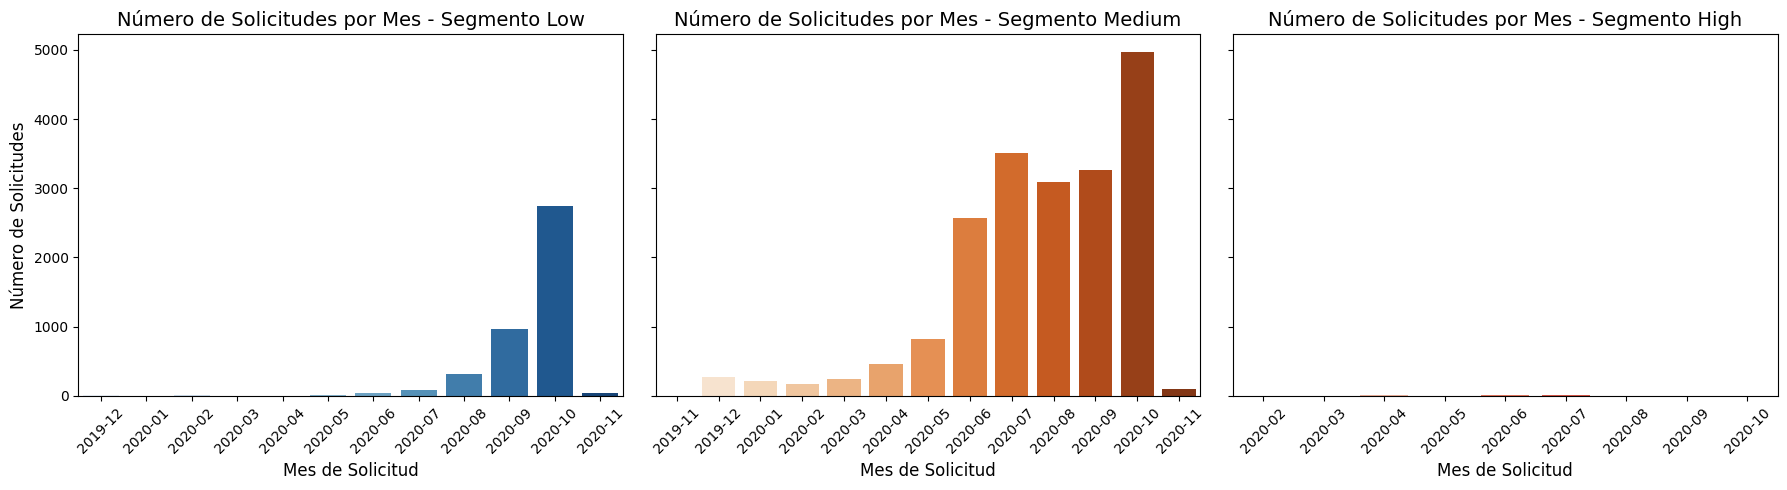

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir la columna de fecha a formato datetime si aún no está en ese formato
cr["mes_solicitud"] = pd.to_datetime(cr["created_at"], errors="coerce").dt.to_period("M")

# Agregar la columna 'segmento' basada en grouped_users
cr["segmento"] = cr["id_completo"].map({user_id: segment for segment, user_ids in grouped_users.items() for user_id in user_ids})

# Filtrar datos por segmento
low_users_df = cr[cr["segmento"] == "Low"]
medium_users_df = cr[cr["segmento"] == "Medium"]
high_users_df = cr[cr["segmento"] == "High"]

# Función para calcular el número de solicitudes por mes
def calcular_solicitudes_mes(df):
    return df["mes_solicitud"].value_counts().sort_index()

# Obtener datos de solicitudes por mes para cada segmento
solicitudes_low = calcular_solicitudes_mes(low_users_df)
solicitudes_medium = calcular_solicitudes_mes(medium_users_df)
solicitudes_high = calcular_solicitudes_mes(high_users_df)

# Definir paletas de colores para cada segmento
colores_segmentos = {"Low": "Blues", "Medium": "Oranges", "High": "Reds"}

# Generar gráficos de barras para cada segmento
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (segmento, data) in enumerate(zip(["Low", "Medium", "High"],
                                         [solicitudes_low, solicitudes_medium, solicitudes_high])):
    sns.barplot(ax=axes[i], x=data.index.astype(str), y=data.values, palette=colores_segmentos[segmento])
    axes[i].set_xlabel("Mes de Solicitud", fontsize=12)
    axes[i].set_ylabel("Número de Solicitudes", fontsize=12)
    axes[i].set_title(f"Número de Solicitudes por Mes - Segmento {segmento}", fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)

# Ajustar diseño y mostrar gráficos
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-29-b106227f364e>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=solicitudes_mes.index.astype(str), y=solicitudes_mes.values, palette=palette)


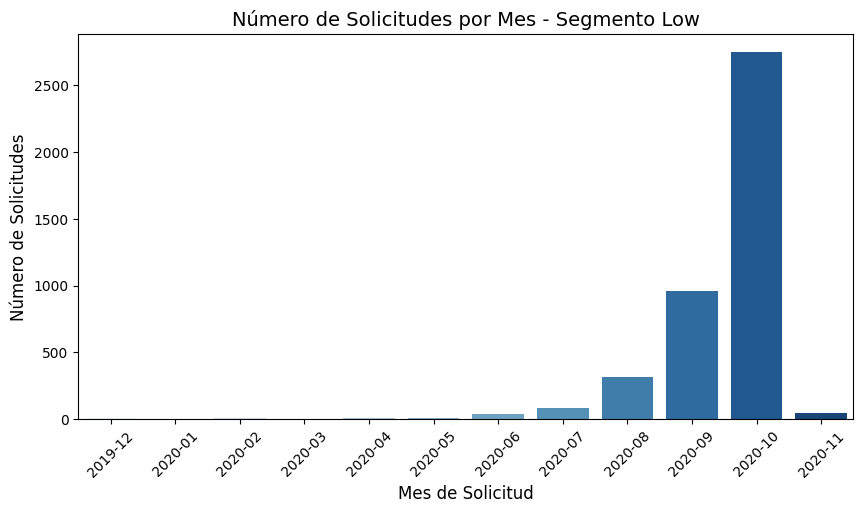

<ipython-input-29-b106227f364e>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=solicitudes_mes.index.astype(str), y=solicitudes_mes.values, palette=palette)


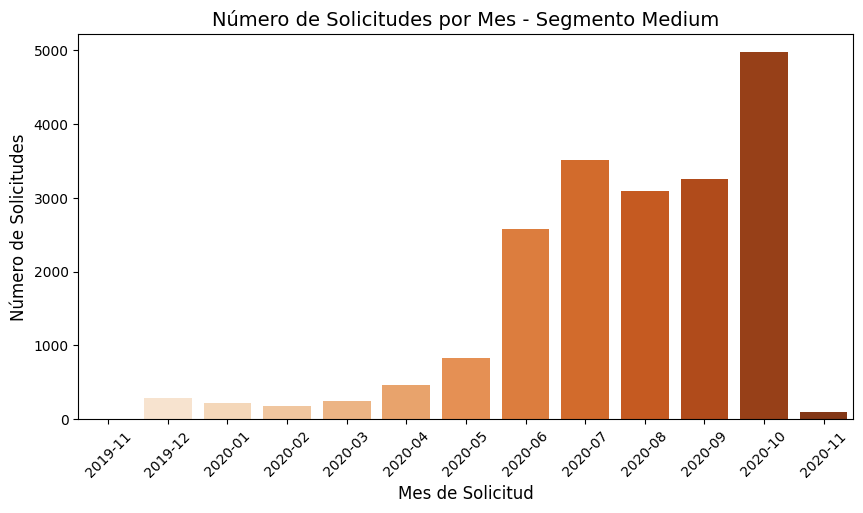

<ipython-input-29-b106227f364e>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=solicitudes_mes.index.astype(str), y=solicitudes_mes.values, palette=palette)


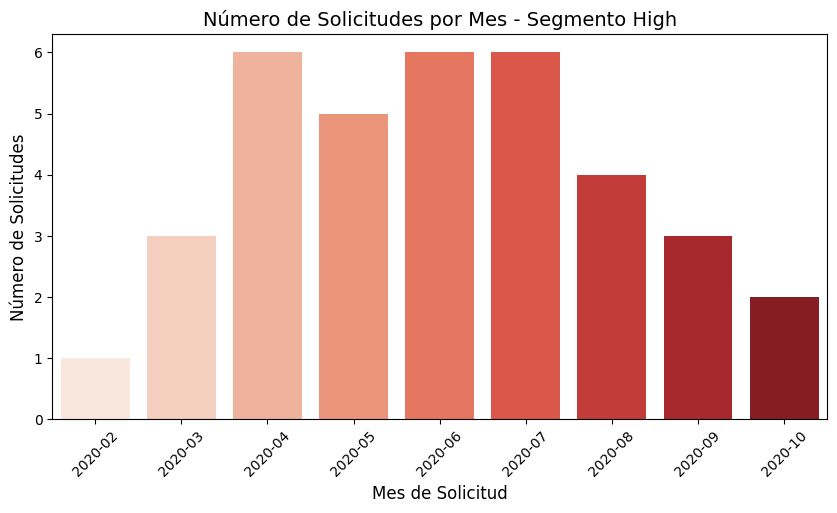

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Agregar la columna 'segmento' al DataFrame original
cr["segmento"] = cr["id_completo"].map({user_id: segment for segment, user_ids in grouped_users.items() for user_id in user_ids})

# Convertir la columna de fecha en formato datetime si no lo está
cr["created_at"] = pd.to_datetime(cr["created_at"], errors="coerce")

# Crear una nueva columna con el mes y año de la solicitud
cr["mes_solicitud"] = cr["created_at"].dt.to_period("M")

# Filtrar datos por segmento
low_users_df = cr[cr["segmento"] == "Low"]
medium_users_df = cr[cr["segmento"] == "Medium"]
high_users_df = cr[cr["segmento"] == "High"]

# Función para graficar número de solicitudes por mes
def graficar_solicitudes_por_mes(df, segmento, palette):
    solicitudes_mes = df["mes_solicitud"].value_counts().sort_index()

    plt.figure(figsize=(10, 5))
    sns.barplot(x=solicitudes_mes.index.astype(str), y=solicitudes_mes.values, palette=palette)
    plt.xlabel("Mes de Solicitud", fontsize=12)
    plt.ylabel("Número de Solicitudes", fontsize=12)
    plt.title(f"Número de Solicitudes por Mes - Segmento {segmento}", fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# Generar gráficos para cada segmento con diferentes paletas de colores
graficar_solicitudes_por_mes(low_users_df, "Low", "Blues")
graficar_solicitudes_por_mes(medium_users_df, "Medium", "Oranges")
graficar_solicitudes_por_mes(high_users_df, "High", "Reds")


# HEAT MAPS POR COHORTE (Low, Medium, High) combinados

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importli

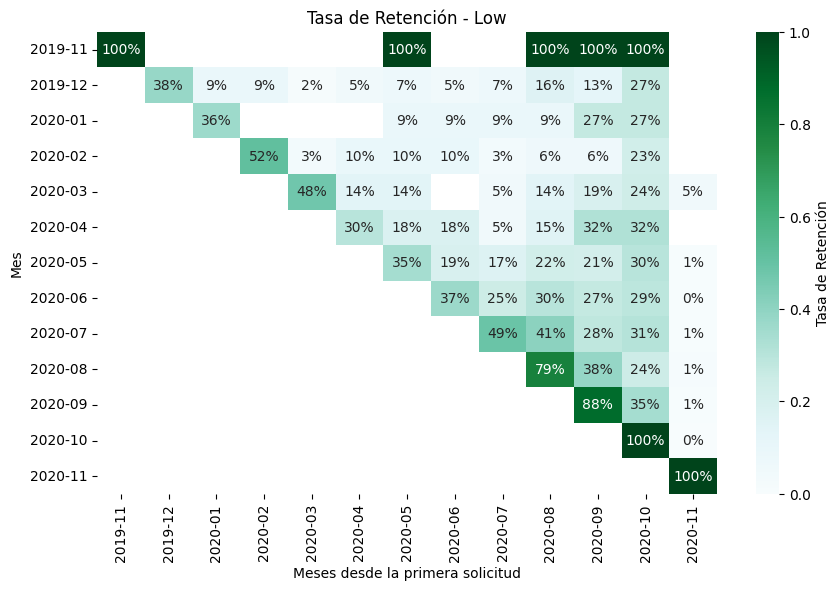

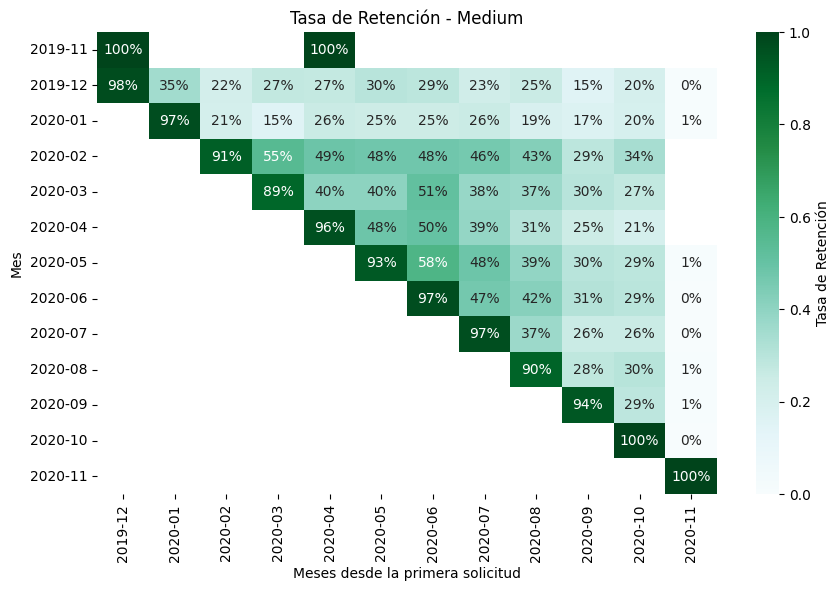

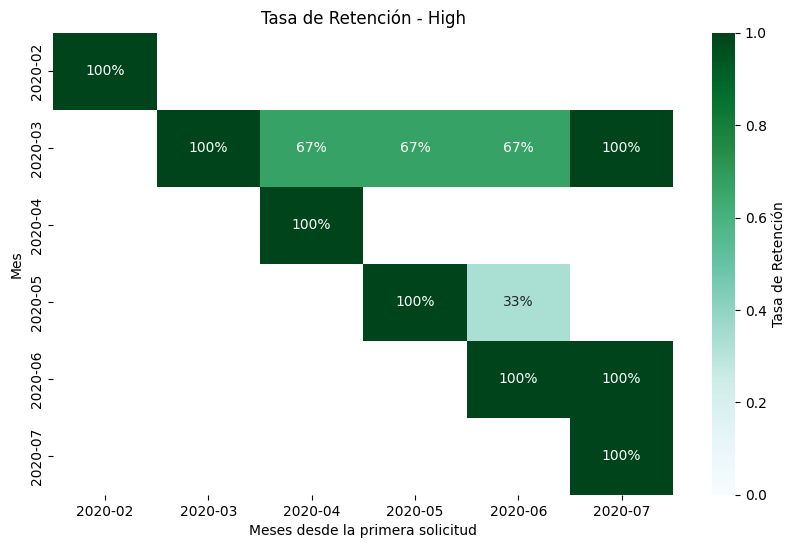

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Iterar sobre los segmentos de gasto para generar gráficos separados
for segment in labels:
    # Filtrar datos por segmento
    cohort_segment = cr[cr['spend_segment'] == segment]

    # Calcular la tasa de retención específica por segmento
    retention_clientes_segment = cohort_segment.pivot_table(index='Primera_Solicitud',
                                                            columns='Mes',
                                                            values='id_completo',
                                                            aggfunc='nunique')
    retention_clientes_segment = retention_clientes_segment.div(cohort_segment.groupby('Primera_Solicitud')['id_completo'].nunique(), axis=0)

    # Crear un gráfico individual para cada segmento
    plt.figure(figsize=(10, 6))
    plt.title(f'Tasa de Retención - {segment}')

    # Visualizar la tasa de retención con un mapa de calor
    sns.heatmap(data=retention_clientes_segment, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='BuGn', cbar_kws={'label': 'Tasa de Retención'})

    plt.xlabel('Meses desde la primera solicitud')
    plt.ylabel('Mes')

    # Mostrar el gráfico
    plt.show()

Solo usuarios actuales

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


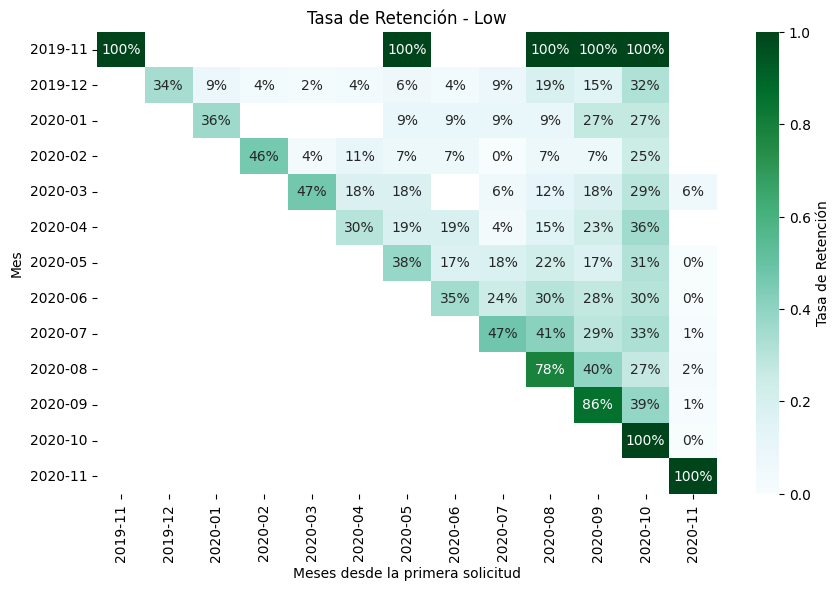

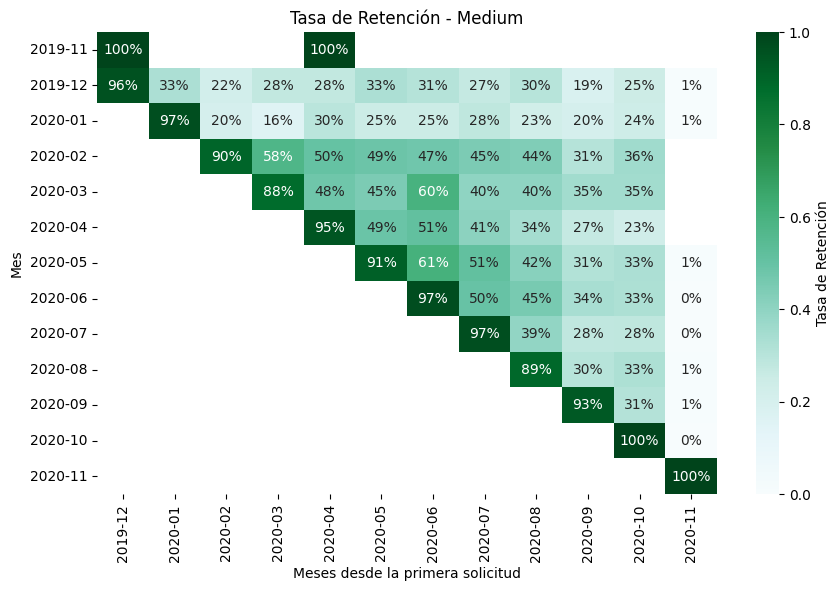

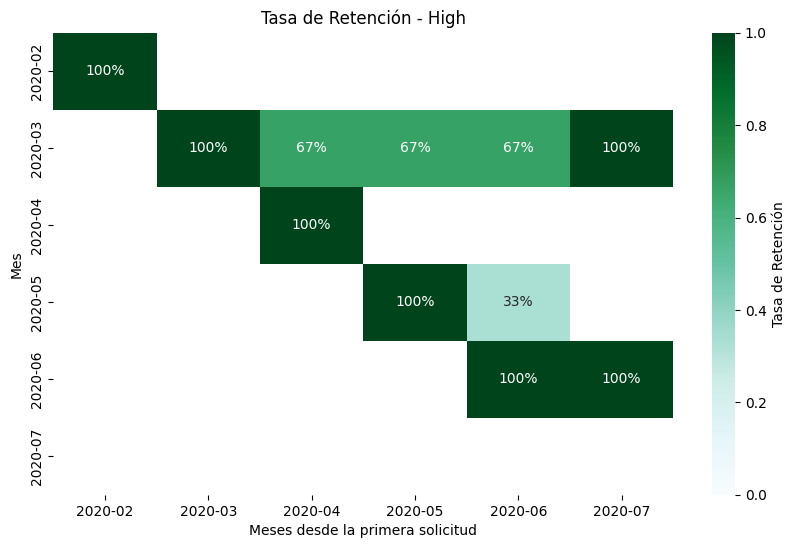

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Iterar sobre los segmentos de gasto para generar gráficos separados
for segment in labels:
    # Filtrar datos por segmento
    cohort_segment = cr[cr['spend_segment'] == segment]

    # Calcular la tasa de retención específica por segmento
    retention_clientes_segment = cohort_segment.pivot_table(index='Primera_Solicitud',
                                                            columns='Mes',
                                                            values='user_id',
                                                            aggfunc='nunique')
    retention_clientes_segment = retention_clientes_segment.div(cohort_segment.groupby('Primera_Solicitud')['user_id'].nunique(), axis=0)

    # Crear un gráfico individual para cada segmento
    plt.figure(figsize=(10, 6))
    plt.title(f'Tasa de Retención - {segment}')

    # Visualizar la tasa de retención con un mapa de calor
    sns.heatmap(data=retention_clientes_segment, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='BuGn', cbar_kws={'label': 'Tasa de Retención'})

    plt.xlabel('Meses desde la primera solicitud')
    plt.ylabel('Mes')

    # Mostrar el gráfico
    plt.show()

Solo usuarios eliminados

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


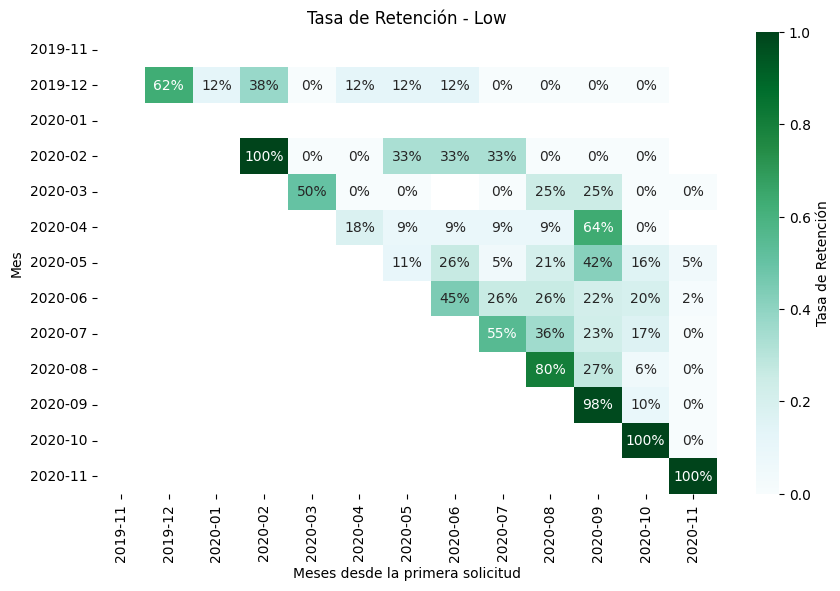

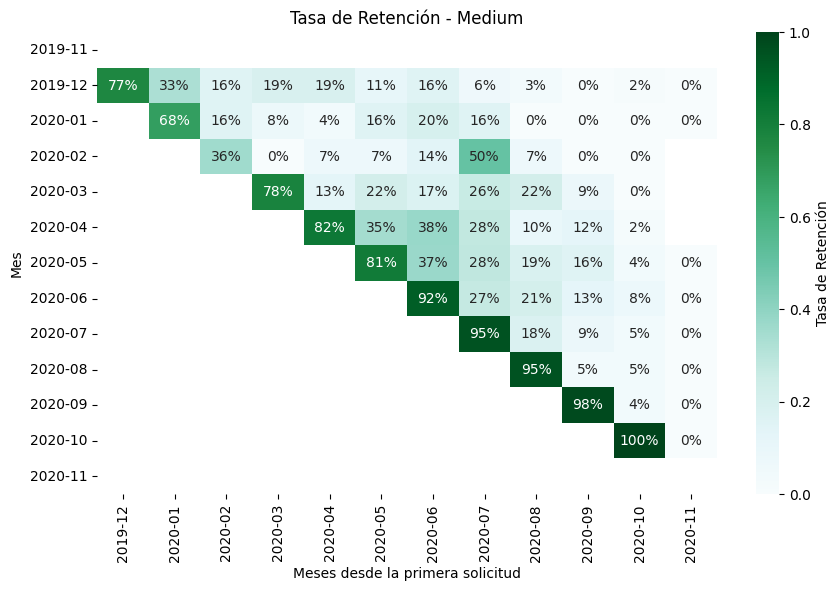

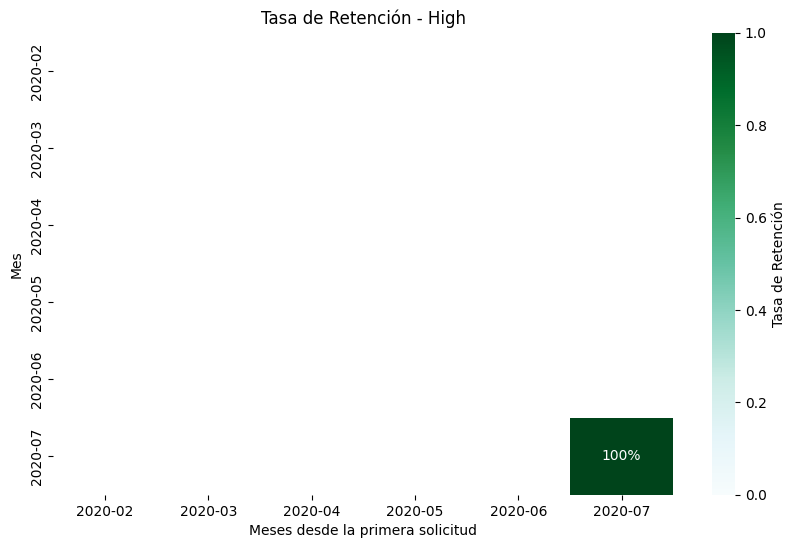

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Iterar sobre los segmentos de gasto para generar gráficos separados
for segment in labels:
    # Filtrar datos por segmento
    cohort_segment = cr[cr['spend_segment'] == segment]

    # Calcular la tasa de retención específica por segmento
    retention_clientes_segment = cohort_segment.pivot_table(index='Primera_Solicitud',
                                                            columns='Mes',
                                                            values='deleted_account_id',
                                                            aggfunc='nunique')
    retention_clientes_segment = retention_clientes_segment.div(cohort_segment.groupby('Primera_Solicitud')['deleted_account_id'].nunique(), axis=0)

    # Crear un gráfico individual para cada segmento
    plt.figure(figsize=(10, 6))
    plt.title(f'Tasa de Retención - {segment}')

    # Visualizar la tasa de retención con un mapa de calor
    sns.heatmap(data=retention_clientes_segment, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='BuGn', cbar_kws={'label': 'Tasa de Retención'})

    plt.xlabel('Meses desde la primera solicitud')
    plt.ylabel('Mes')

    # Mostrar el gráfico
    plt.show()

## Matriz acumulados

Usuarios actuales

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


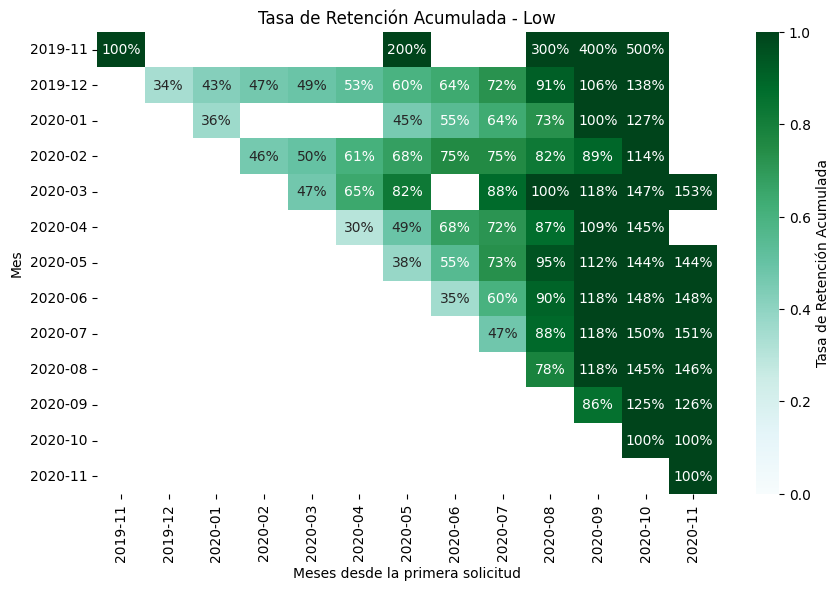

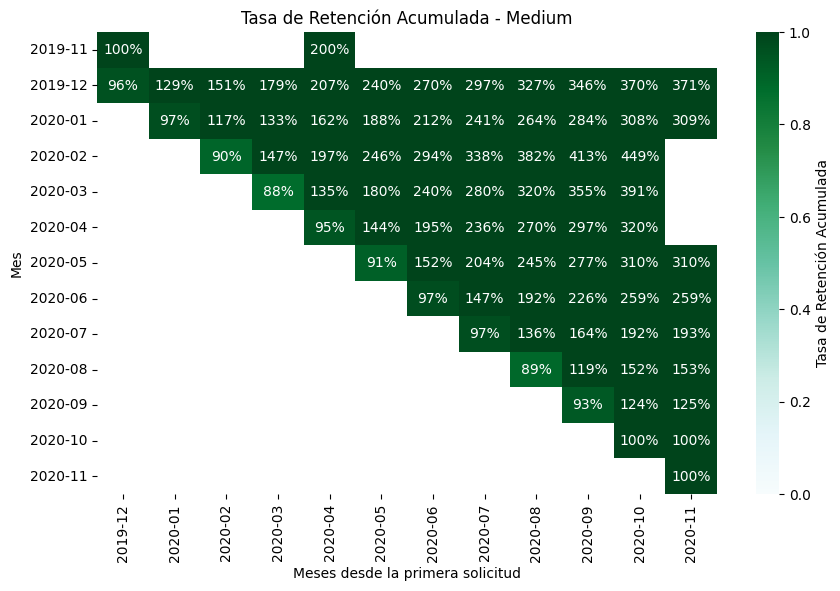

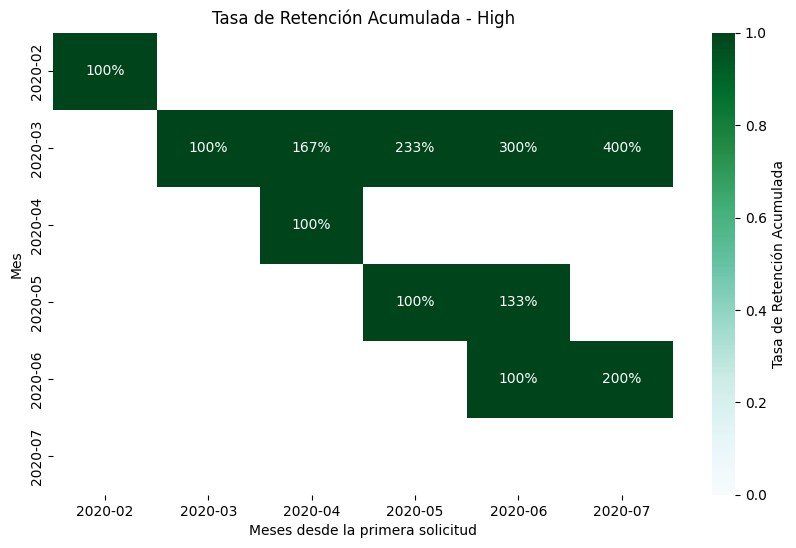

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir los bins y etiquetas para los segmentos de gasto
bins = [cr['amount'].min(), 50, 150, cr['amount'].max()]
labels = ['Low', 'Medium', 'High']

# Asignar cada usuario a un segmento de gasto
cr['spend_segment'] = pd.cut(cr['amount'], bins=bins, labels=labels, include_lowest=True)

# Iterar sobre los segmentos de gasto para generar gráficos separados con valores acumulados
for segment in labels:
    # Filtrar datos por segmento
    cohort_segment = cr[cr['spend_segment'] == segment]

    # Calcular la tasa de retención específica por segmento
    retention_clientes_segment = cohort_segment.pivot_table(index='Primera_Solicitud',
                                                            columns='Mes',
                                                            values='user_id',
                                                            aggfunc='nunique')

    # Convertir los valores en acumulativos (suma progresiva por fila)
    retention_clientes_segment = retention_clientes_segment.cumsum(axis=1)

    # Normalizar dividiendo por la cantidad inicial de usuarios en cada cohorte
    retention_clientes_segment = retention_clientes_segment.div(cohort_segment.groupby('Primera_Solicitud')['user_id'].nunique(), axis=0)

    # Crear un gráfico individual para cada segmento
    plt.figure(figsize=(10, 6))
    plt.title(f'Tasa de Retención Acumulada - {segment}')

    # Visualizar la tasa de retención con un mapa de calor
    sns.heatmap(data=retention_clientes_segment, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='BuGn', cbar_kws={'label': 'Tasa de Retención Acumulada'})

    plt.xlabel('Meses desde la primera solicitud')
    plt.ylabel('Mes')

    # Mostrar el gráfico
    plt.show()


Usuarios eliminados

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


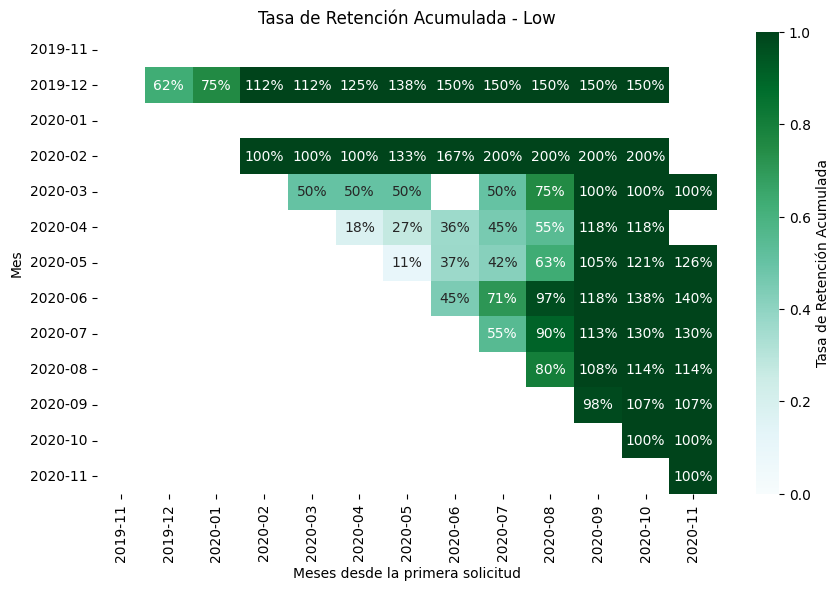

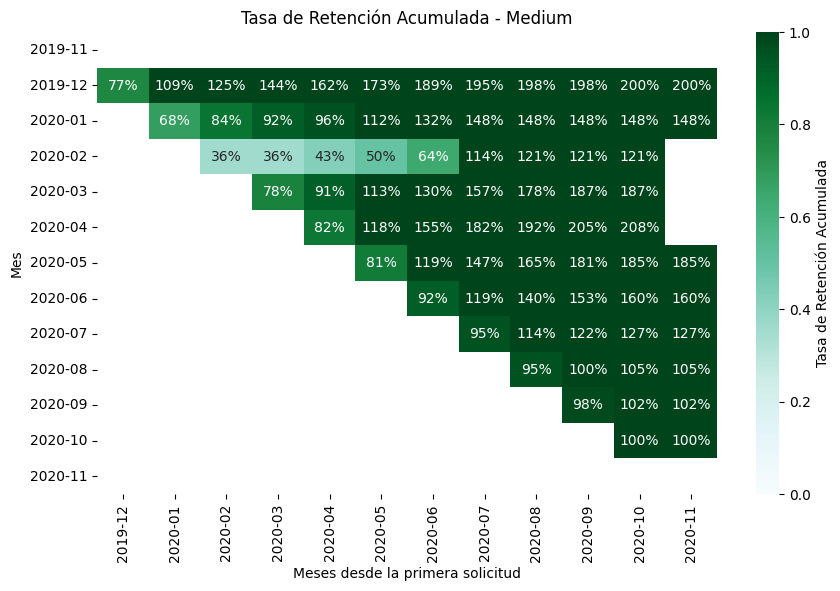

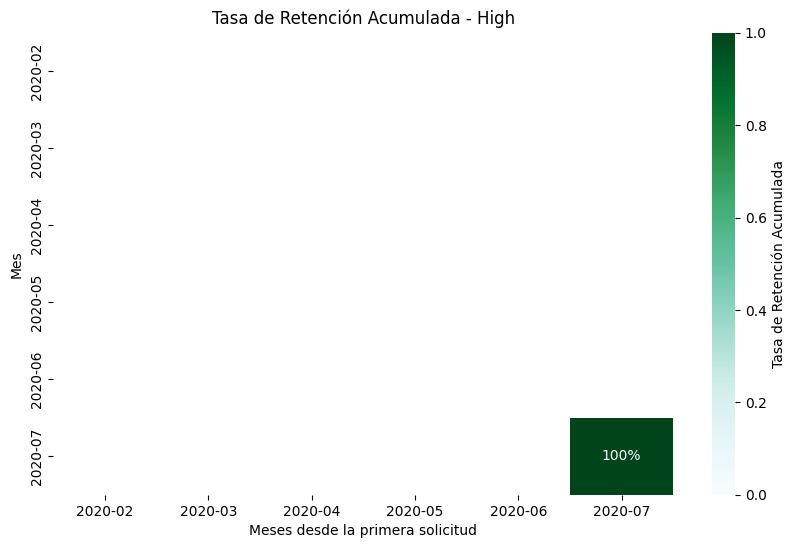

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir los bins y etiquetas para los segmentos de gasto
bins = [cr['amount'].min(), 50, 150, cr['amount'].max()]
labels = ['Low', 'Medium', 'High']

# Asignar cada usuario a un segmento de gasto
cr['spend_segment'] = pd.cut(cr['amount'], bins=bins, labels=labels, include_lowest=True)

# Iterar sobre los segmentos de gasto para generar gráficos separados con valores acumulados
for segment in labels:
    # Filtrar datos por segmento
    cohort_segment = cr[cr['spend_segment'] == segment]

    # Calcular la tasa de retención específica por segmento
    retention_clientes_segment = cohort_segment.pivot_table(index='Primera_Solicitud',
                                                            columns='Mes',
                                                            values='deleted_account_id',
                                                            aggfunc='nunique')

    # Convertir los valores en acumulativos (suma progresiva por fila)
    retention_clientes_segment = retention_clientes_segment.cumsum(axis=1)

    # Normalizar dividiendo por la cantidad inicial de usuarios en cada cohorte
    retention_clientes_segment = retention_clientes_segment.div(cohort_segment.groupby('Primera_Solicitud')['deleted_account_id'].nunique(), axis=0)

    # Crear un gráfico individual para cada segmento
    plt.figure(figsize=(10, 6))
    plt.title(f'Tasa de Retención Acumulada - {segment}')

    # Visualizar la tasa de retención con un mapa de calor
    sns.heatmap(data=retention_clientes_segment, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='BuGn', cbar_kws={'label': 'Tasa de Retención Acumulada'})

    plt.xlabel('Meses desde la primera solicitud')
    plt.ylabel('Mes')

    # Mostrar el gráfico
    plt.show()


Combinados

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


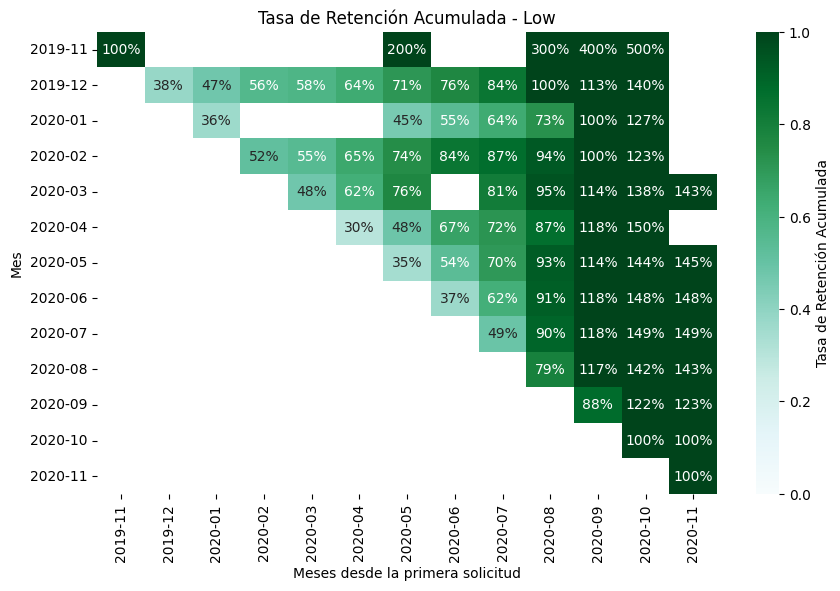

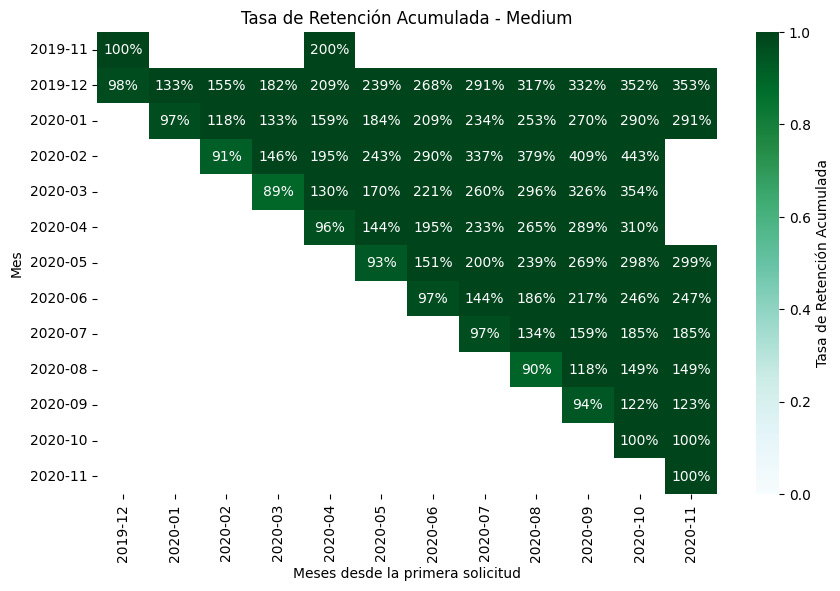

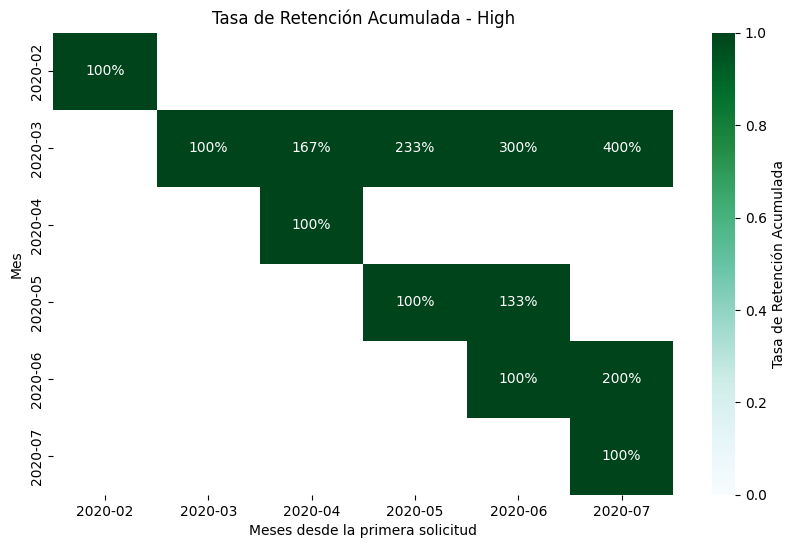

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir los bins y etiquetas para los segmentos de gasto
bins = [cr['amount'].min(), 50, 150, cr['amount'].max()]
labels = ['Low', 'Medium', 'High']

# Asignar cada usuario a un segmento de gasto
cr['spend_segment'] = pd.cut(cr['amount'], bins=bins, labels=labels, include_lowest=True)

# Iterar sobre los segmentos de gasto para generar gráficos separados con valores acumulados
for segment in labels:
    # Filtrar datos por segmento
    cohort_segment = cr[cr['spend_segment'] == segment]

    # Calcular la tasa de retención específica por segmento
    retention_clientes_segment = cohort_segment.pivot_table(index='Primera_Solicitud',
                                                            columns='Mes',
                                                            values='id_completo',
                                                            aggfunc='nunique')

    # Convertir los valores en acumulativos (suma progresiva por fila)
    retention_clientes_segment = retention_clientes_segment.cumsum(axis=1)

    # Normalizar dividiendo por la cantidad inicial de usuarios en cada cohorte
    retention_clientes_segment = retention_clientes_segment.div(cohort_segment.groupby('Primera_Solicitud')['id_completo'].nunique(), axis=0)

    # Crear un gráfico individual para cada segmento
    plt.figure(figsize=(10, 6))
    plt.title(f'Tasa de Retención Acumulada - {segment}')

    # Visualizar la tasa de retención con un mapa de calor
    sns.heatmap(data=retention_clientes_segment, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='BuGn', cbar_kws={'label': 'Tasa de Retención Acumulada'})

    plt.xlabel('Meses desde la primera solicitud')
    plt.ylabel('Mes')

    # Mostrar el gráfico
    plt.show()

In [36]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cash_id                     23970 non-null  int64         
 1   amount                      23970 non-null  float64       
 2   status                      23970 non-null  object        
 3   created_at                  23970 non-null  datetime64[ns]
 4   updated_at                  23970 non-null  object        
 5   user_id                     21867 non-null  float64       
 6   moderated_at                16035 non-null  object        
 7   deleted_account_id          2104 non-null   float64       
 8   reimbursement_date          23970 non-null  object        
 9   cash_request_received_date  16289 non-null  object        
 10  money_back_date             16543 non-null  object        
 11  transfer_type               23970 non-null  object    

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
cr.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cash_id  amount    status                 created_at  \
0        5   100.0  rejected 2019-12-10 19:05:21.596873   
1       70   100.0  rejected 2019-12-10 19:50:12.347780   
2        7   100.0  rejected 2019-12-10 19:13:35.825460   
3       10    99.0  rejected 2019-12-10 19:16:10.880172   
4     1594   100.0  rejected 2020-05-06 09:59:38.877376   

                      updated_at  user_id                   moderated_at  \
0   2019-12-11 16:47:42.40783+00    804.0  2019-12-11 16:47:42.405646+00   
1  2019-12-11 14:24:22.900054+00    231.0  2019-12-11 14:24:22.897988+00   
2  2019-12-11 09:46:59.779773+00    191.0  2019-12-11 09:46:59.777728+00   
3  2019-12-18 14:26:18.136163+00    761.0  2019-12-18 14:26:18.128407+00   
4   2020-05-07 09:21:55.34008+00   7686.0  2020-05-07 09:21:55.320193+00   

   deleted_account_id             reimbursement_date  \
0                 NaN  2020-01-09 19:05:21.596363+00   
1                 NaN   2020-01-09 19:50:12.34778+00   
2                 NaN  2020-01-09 19:13:35.825041+00   
3                 NaN  2020-01-09 19:16:10.879606+00   
4                 NaN         2020-06-05 22:00:00+00   

  cash_request_received_date  ... reco_last_update id_completo      Mes  \
0                        NaN  ...              NaN         804  2019-12   
1                        NaN  ...              NaN         231  2019-12   
2                        NaN  ...              NaN         191  2019-12   
3                        NaN  ...              NaN         761  2019-12   
4                        NaN  ...              NaN        7686  2020-05   

                  Semana         Día      Hora  Primera_Solicitud  \
0  2019-12-09/2019-12-15  2019-12-10  19:05:21            2019-12   
1  2019-12-09/2019-12-15  2019-12-10  19:50:12            2019-12   
2  2019-12-09/2019-12-15  2019-12-10  19:13:35            2019-12   
3  2019-12-09/2019-12-15  2019-12-10  19:16:10            2019-12   
4  2020-05-04/2020-05-10  2020-05-06  09:59:38            2020-05   

  spend_segment mes_solicitud segmento  
0        Medium       2019-12   Medium  
1        Medium       2019-12   Medium  
2        Medium       2019-12   Medium  
3        Medium       2019-12   Medium  
4        Medium       2020-05   Medium  

[5 rows x 25 columns]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


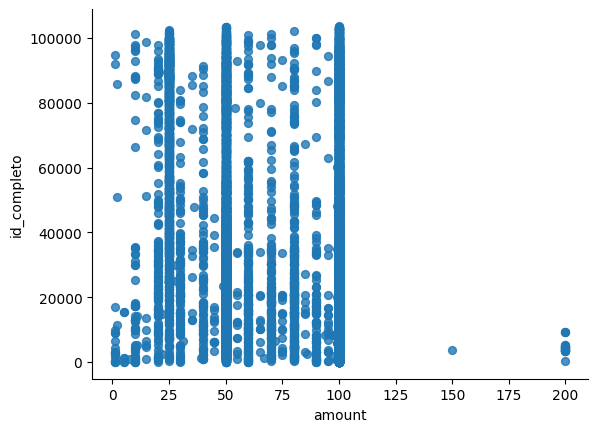

In [38]:
# @title amount vs id_completo

from matplotlib import pyplot as plt
cr.plot(kind='scatter', x='amount', y='id_completo', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


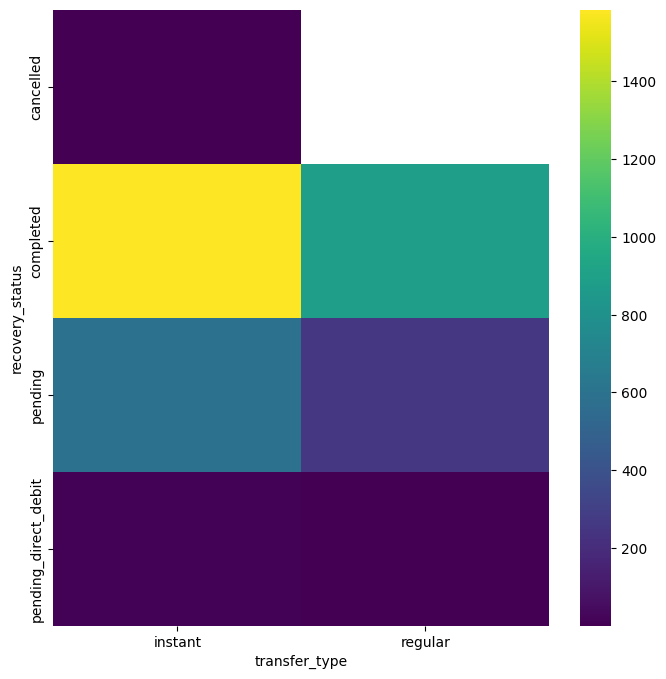

In [39]:
# @title transfer_type vs recovery_status

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['recovery_status'].value_counts()
    for x_label, grp in cr.groupby('transfer_type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('transfer_type')
_ = plt.ylabel('recovery_status')

RECOVERY_STATUS vs SPEND_SEGMENT

In [40]:
cr.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cash_id  amount    status                 created_at  \
0        5   100.0  rejected 2019-12-10 19:05:21.596873   
1       70   100.0  rejected 2019-12-10 19:50:12.347780   
2        7   100.0  rejected 2019-12-10 19:13:35.825460   
3       10    99.0  rejected 2019-12-10 19:16:10.880172   
4     1594   100.0  rejected 2020-05-06 09:59:38.877376   

                      updated_at  user_id                   moderated_at  \
0   2019-12-11 16:47:42.40783+00    804.0  2019-12-11 16:47:42.405646+00   
1  2019-12-11 14:24:22.900054+00    231.0  2019-12-11 14:24:22.897988+00   
2  2019-12-11 09:46:59.779773+00    191.0  2019-12-11 09:46:59.777728+00   
3  2019-12-18 14:26:18.136163+00    761.0  2019-12-18 14:26:18.128407+00   
4   2020-05-07 09:21:55.34008+00   7686.0  2020-05-07 09:21:55.320193+00   

   deleted_account_id             reimbursement_date  \
0                 NaN  2020-01-09 19:05:21.596363+00   
1                 NaN   2020-01-09 19:50:12.34778+00   
2                 NaN  2020-01-09 19:13:35.825041+00   
3                 NaN  2020-01-09 19:16:10.879606+00   
4                 NaN         2020-06-05 22:00:00+00   

  cash_request_received_date  ... reco_last_update id_completo      Mes  \
0                        NaN  ...              NaN         804  2019-12   
1                        NaN  ...              NaN         231  2019-12   
2                        NaN  ...              NaN         191  2019-12   
3                        NaN  ...              NaN         761  2019-12   
4                        NaN  ...              NaN        7686  2020-05   

                  Semana         Día      Hora  Primera_Solicitud  \
0  2019-12-09/2019-12-15  2019-12-10  19:05:21            2019-12   
1  2019-12-09/2019-12-15  2019-12-10  19:50:12            2019-12   
2  2019-12-09/2019-12-15  2019-12-10  19:13:35            2019-12   
3  2019-12-09/2019-12-15  2019-12-10  19:16:10            2019-12   
4  2020-05-04/2020-05-10  2020-05-06  09:59:38            2020-05   

  spend_segment mes_solicitud segmento  
0        Medium       2019-12   Medium  
1        Medium       2019-12   Medium  
2        Medium       2019-12   Medium  
3        Medium       2019-12   Medium  
4        Medium       2020-05   Medium  

[5 rows x 25 columns]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-41-281277b34ff5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(cr, x='cash_id', y='status', inner='box', palette='Dark2')


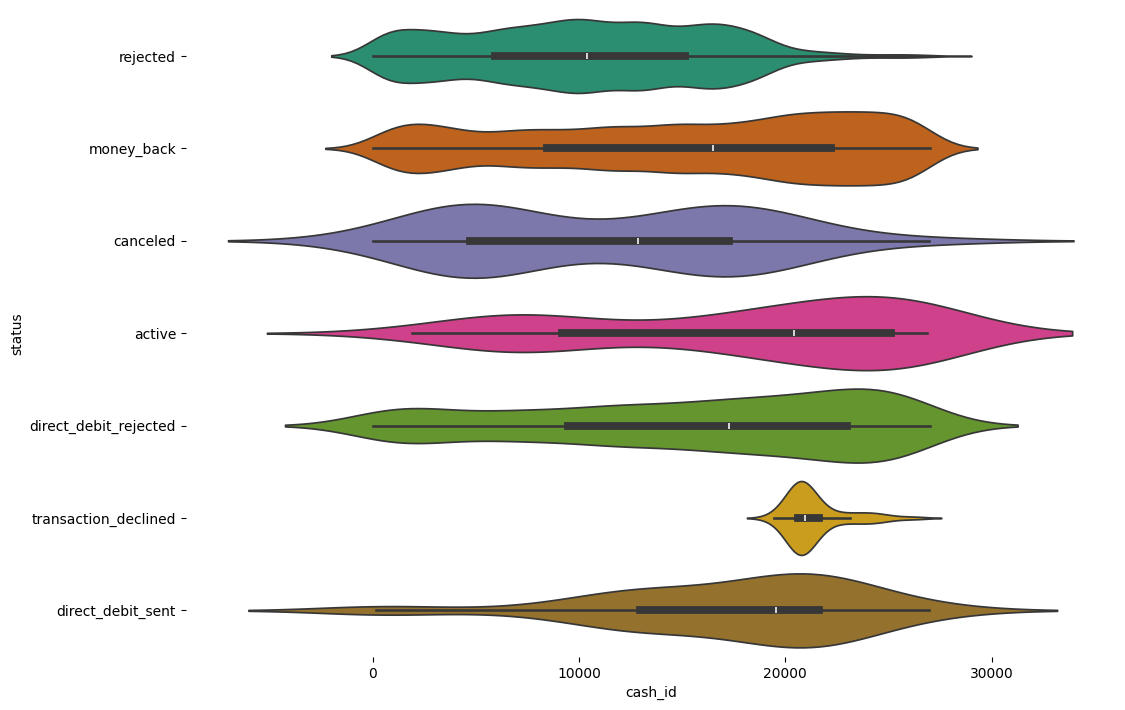

In [41]:
# @title status vs cash_id

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(cr['status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(cr, x='cash_id', y='status', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-42-7b5438e30d0a>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="id_completo", y="status", inner="box", palette=palette)


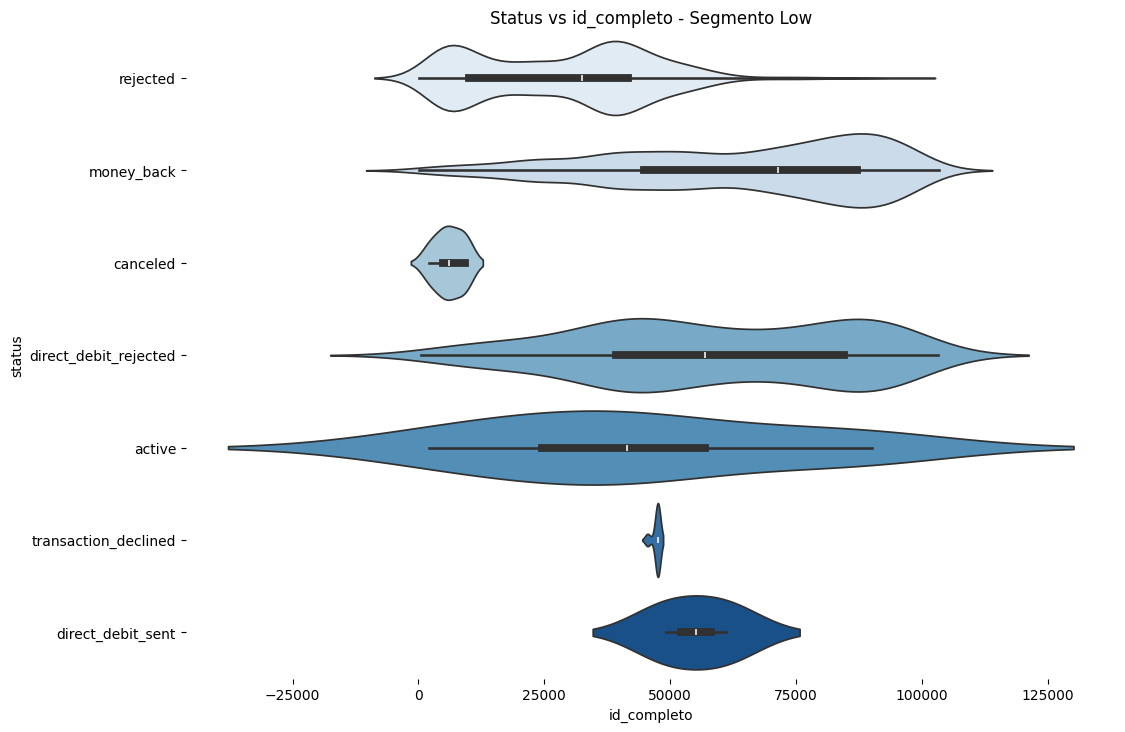

<ipython-input-42-7b5438e30d0a>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="id_completo", y="status", inner="box", palette=palette)


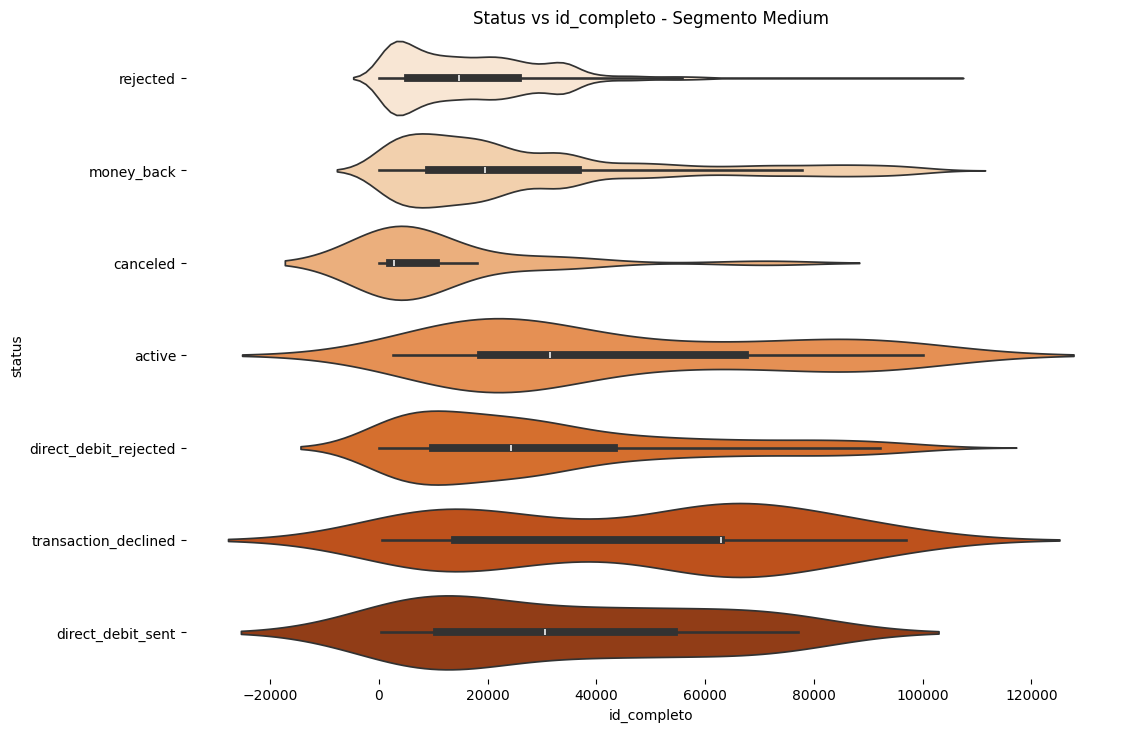

<ipython-input-42-7b5438e30d0a>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="id_completo", y="status", inner="box", palette=palette)


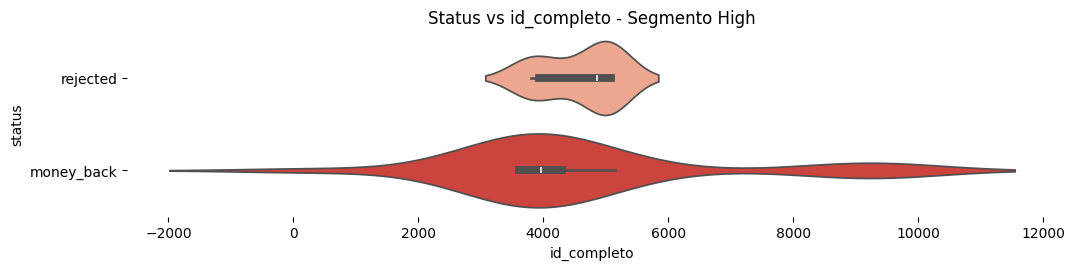

In [42]:
# @title status vs cash_id por segmento

import matplotlib.pyplot as plt
import seaborn as sns

# Agregar la columna 'segmento' al DataFrame original
cr["segmento"] = cr["id_completo"].map({user_id: segment for segment, user_ids in grouped_users.items() for user_id in user_ids})

# Filtrar datos por segmento
low_users_df = cr[cr["segmento"] == "Low"]
medium_users_df = cr[cr["segmento"] == "Medium"]
high_users_df = cr[cr["segmento"] == "High"]

# Función para graficar violin plots
def graficar_violin(df, segmento, palette):
    figsize = (12, 1.2 * len(df["status"].unique()))
    plt.figure(figsize=figsize)
    sns.violinplot(data=df, x="id_completo", y="status", inner="box", palette=palette)
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.title(f"Status vs id_completo - Segmento {segmento}")
    plt.show()

# Generar gráficos para cada segmento con diferentes paletas de colores
graficar_violin(low_users_df, "Low", "Blues")
graficar_violin(medium_users_df, "Medium", "Oranges")
graficar_violin(high_users_df, "High", "Reds")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


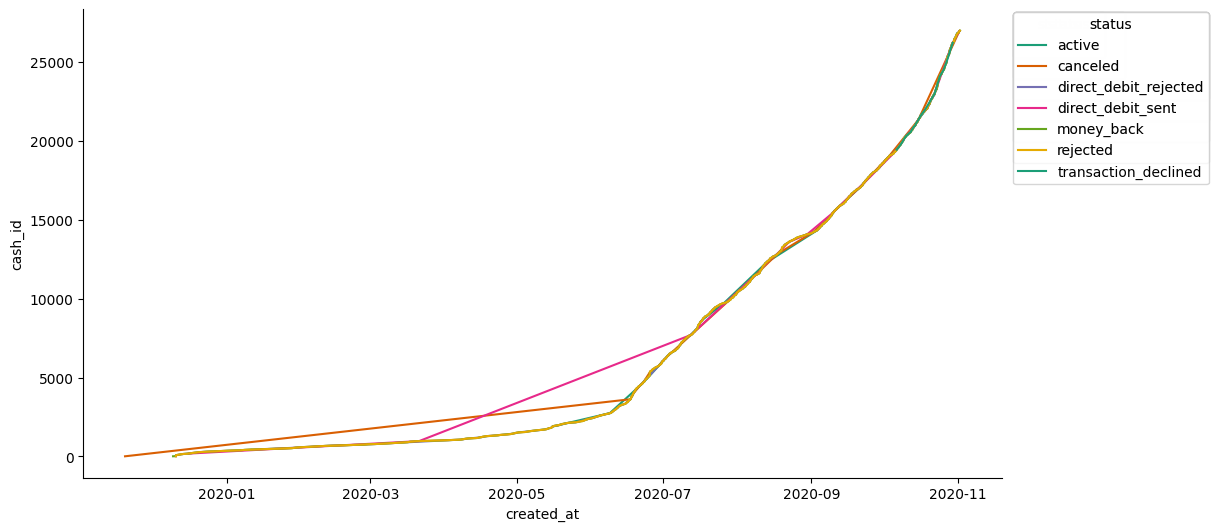

In [43]:
# @title created_at vs cash_id

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['created_at']
  ys = series['cash_id']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cr.sort_values('created_at', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('status')):
  _plot_series(series, series_name, i)
  fig.legend(title='status', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('created_at')
_ = plt.ylabel('cash_id')


In [44]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cash_id                     23970 non-null  int64         
 1   amount                      23970 non-null  float64       
 2   status                      23970 non-null  object        
 3   created_at                  23970 non-null  datetime64[ns]
 4   updated_at                  23970 non-null  object        
 5   user_id                     21867 non-null  float64       
 6   moderated_at                16035 non-null  object        
 7   deleted_account_id          2104 non-null   float64       
 8   reimbursement_date          23970 non-null  object        
 9   cash_request_received_date  16289 non-null  object        
 10  money_back_date             16543 non-null  object        
 11  transfer_type               23970 non-null  object    

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-45-c61e72a77690>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cohort_counts.index.astype(str), y=cohort_counts.values, palette=color)


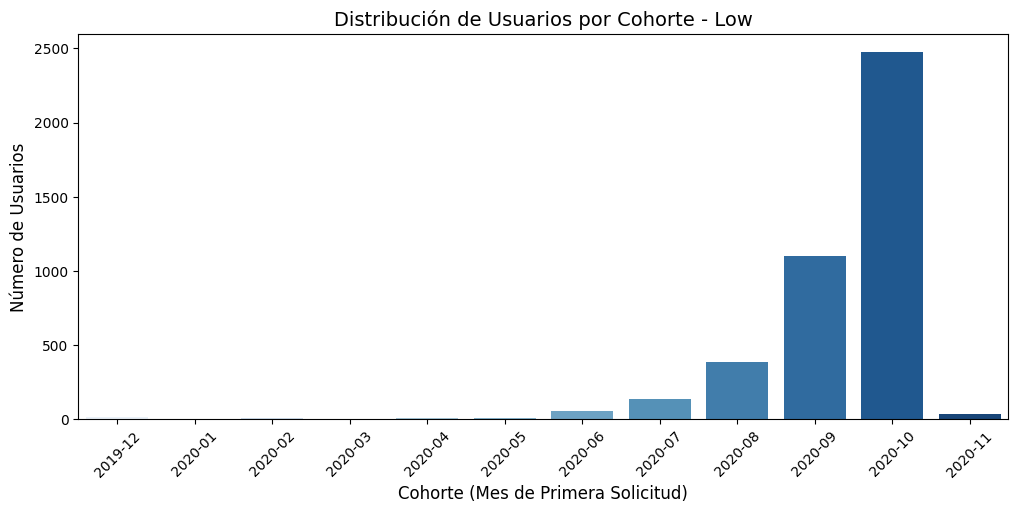

<ipython-input-45-c61e72a77690>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cohort_counts.index.astype(str), y=cohort_counts.values, palette=color)


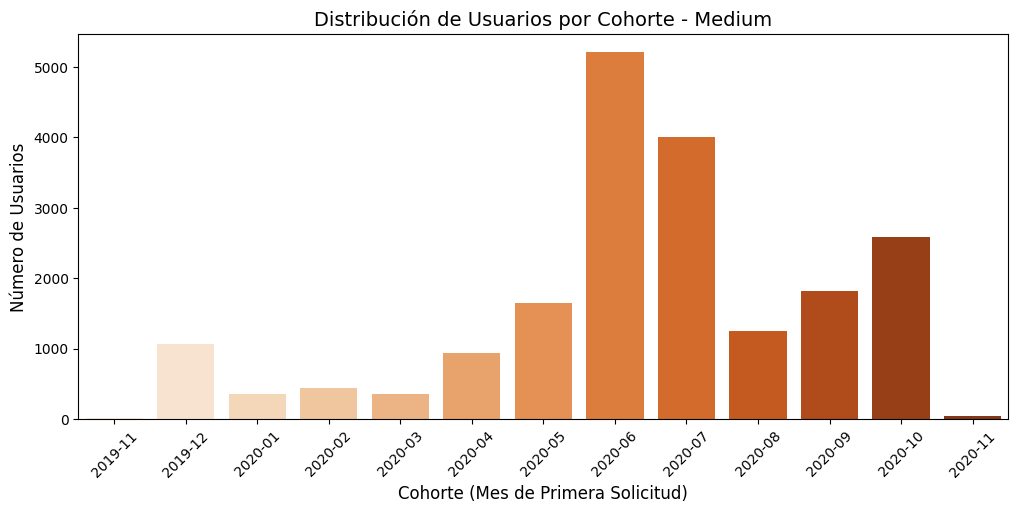

<ipython-input-45-c61e72a77690>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cohort_counts.index.astype(str), y=cohort_counts.values, palette=color)


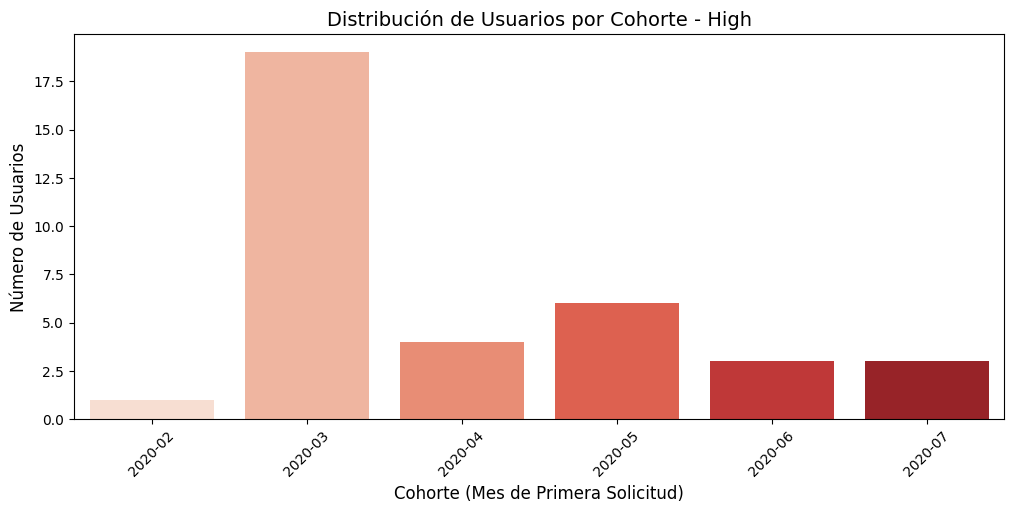

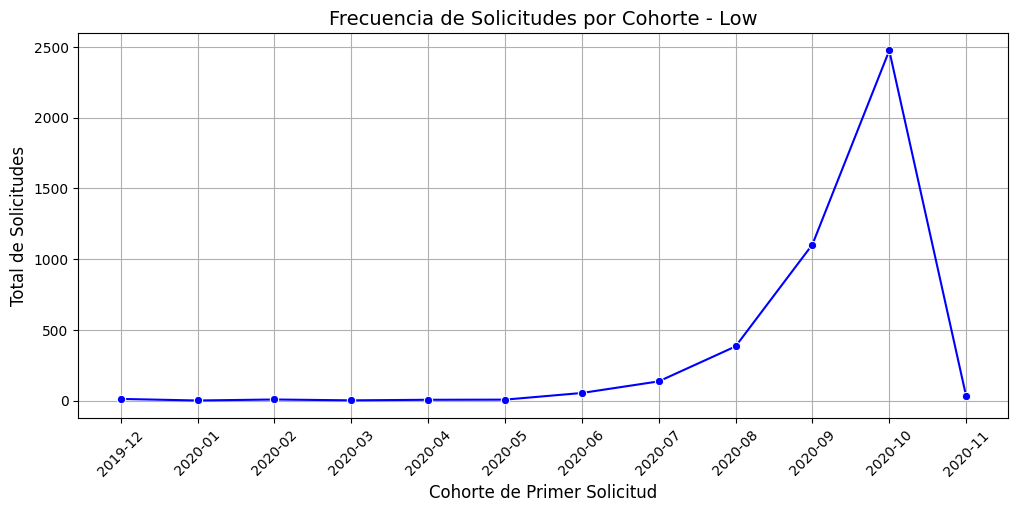

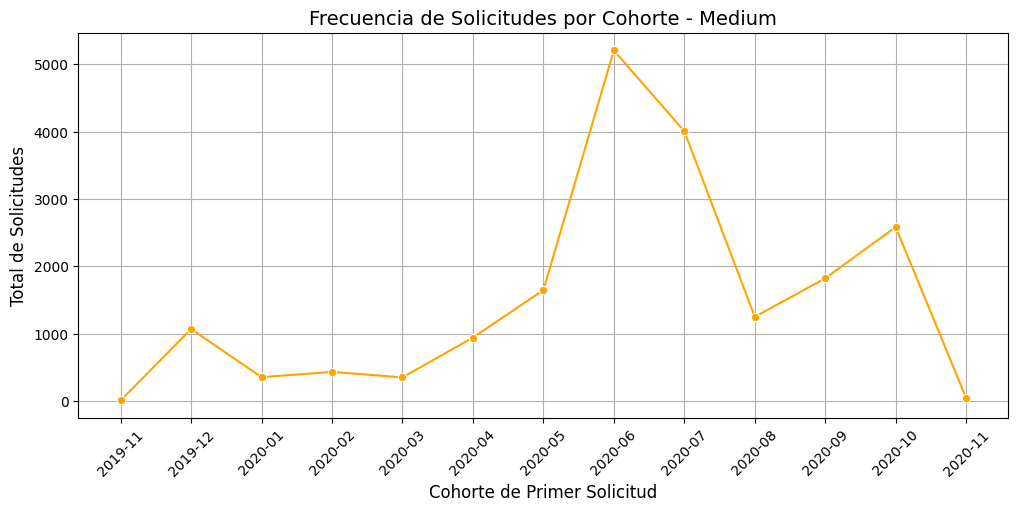

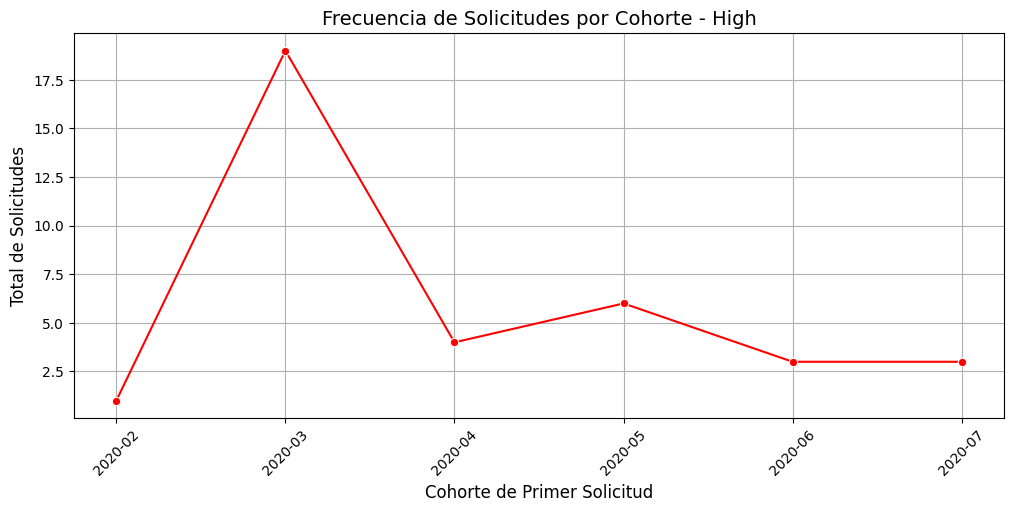

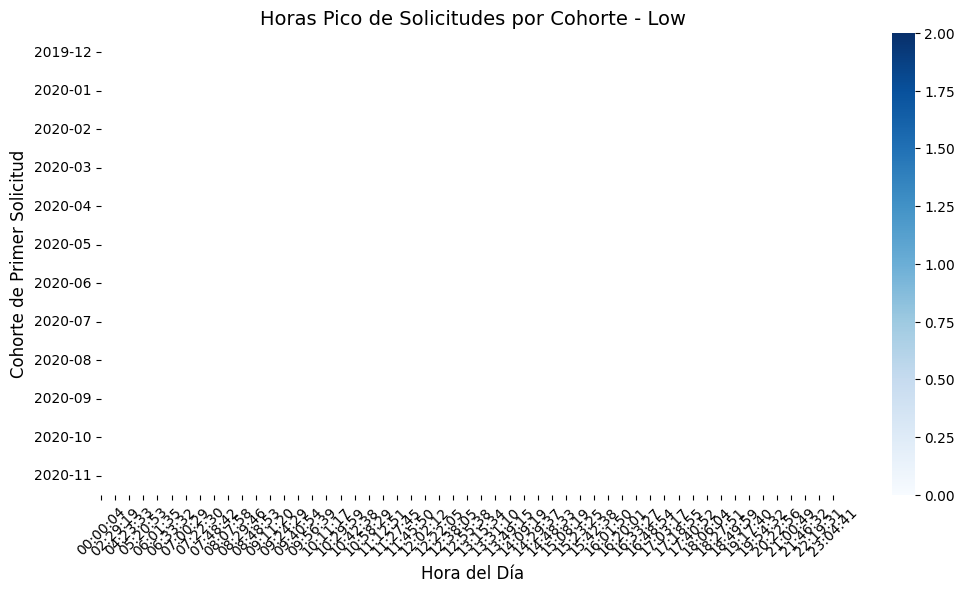

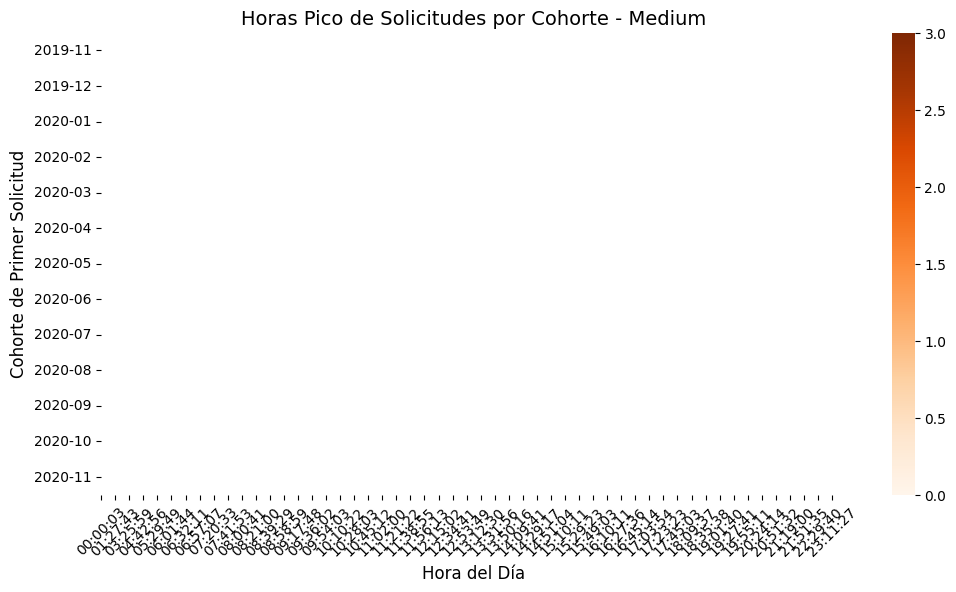

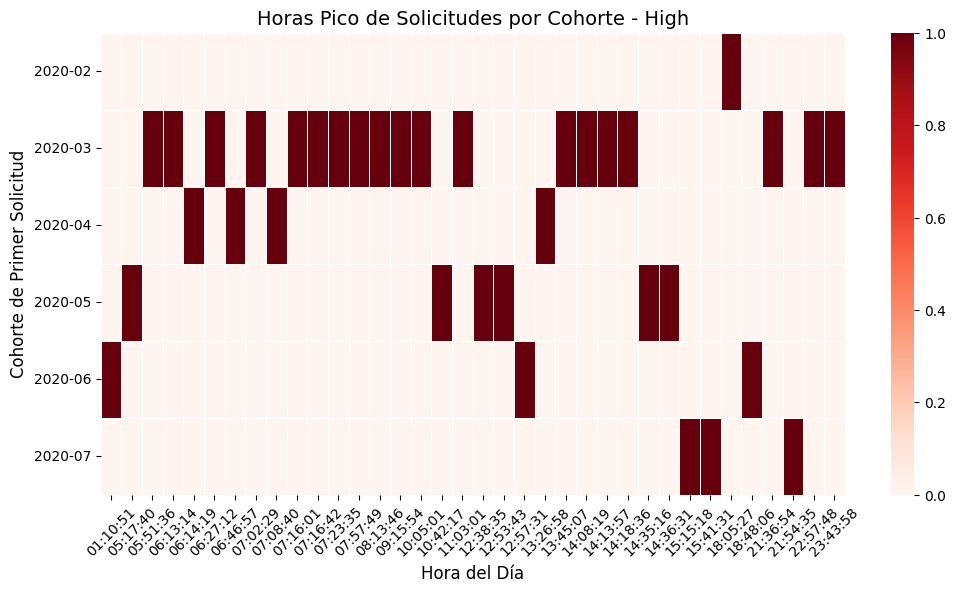

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Agregar la columna 'segmento' al DataFrame original
cr["segmento"] = cr["id_completo"].map({user_id: segment for segment, user_ids in grouped_users.items() for user_id in user_ids})

# Filtrar datos por segmento
low_users_df = cr[cr["segmento"] == "Low"]
medium_users_df = cr[cr["segmento"] == "Medium"]
high_users_df = cr[cr["segmento"] == "High"]

# Función para graficar la cantidad de usuarios por cohorte
def graficar_usuarios_por_cohorte(df, segmento, color):
    cohort_counts = df["Primera_Solicitud"].value_counts().sort_index()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=cohort_counts.index.astype(str), y=cohort_counts.values, palette=color)
    plt.xlabel("Cohorte (Mes de Primera Solicitud)", fontsize=12)
    plt.ylabel("Número de Usuarios", fontsize=12)
    plt.title(f"Distribución de Usuarios por Cohorte - {segmento}", fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# Generar gráficos de distribución por cohorte
graficar_usuarios_por_cohorte(low_users_df, "Low", "Blues")
graficar_usuarios_por_cohorte(medium_users_df, "Medium", "Oranges")
graficar_usuarios_por_cohorte(high_users_df, "High", "Reds")


# Función para graficar la frecuencia de solicitudes por cohorte
def graficar_frecuencia_solicitudes(df, segmento, color):
    cohort_frecuencia = df.groupby("Primera_Solicitud")["id_completo"].count().reset_index()
    cohort_frecuencia.columns = ["Cohorte", "Total_Solicitudes"]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x=cohort_frecuencia["Cohorte"].astype(str), y=cohort_frecuencia["Total_Solicitudes"], marker="o", color=color)
    plt.xlabel("Cohorte de Primer Solicitud", fontsize=12)
    plt.ylabel("Total de Solicitudes", fontsize=12)
    plt.title(f"Frecuencia de Solicitudes por Cohorte - {segmento}", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

# Generar gráficos de frecuencia de solicitudes por cohorte
graficar_frecuencia_solicitudes(low_users_df, "Low", "b")
graficar_frecuencia_solicitudes(medium_users_df, "Medium", "orange")
graficar_frecuencia_solicitudes(high_users_df, "High", "r")


# Función para graficar las horas pico de solicitudes por cohorte
def graficar_horas_pico(df, segmento, color):
    # Change 'hora' to 'Hora' to match the column name in the DataFrame
    horas_pico = df.groupby(["Primera_Solicitud", "Hora"]).size().unstack().fillna(0)

    plt.figure(figsize=(12, 6))
    sns.heatmap(horas_pico, cmap=color, linewidths=0.5, annot=False)
    plt.xlabel("Hora del Día", fontsize=12)
    plt.ylabel("Cohorte de Primer Solicitud", fontsize=12)
    plt.title(f"Horas Pico de Solicitudes por Cohorte - {segmento}", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Generar gráficos de horas pico por cohorte
graficar_horas_pico(low_users_df, "Low", "Blues")
graficar_horas_pico(medium_users_df, "Medium", "Oranges")
graficar_horas_pico(high_users_df, "High", "Reds")

In [48]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cash_id                     23970 non-null  int64         
 1   amount                      23970 non-null  float64       
 2   status                      23970 non-null  object        
 3   created_at                  23970 non-null  datetime64[ns]
 4   updated_at                  23970 non-null  object        
 5   user_id                     21867 non-null  float64       
 6   moderated_at                16035 non-null  object        
 7   deleted_account_id          2104 non-null   float64       
 8   reimbursement_date          23970 non-null  object        
 9   cash_request_received_date  16289 non-null  object        
 10  money_back_date             16543 non-null  object        
 11  transfer_type               23970 non-null  object    

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


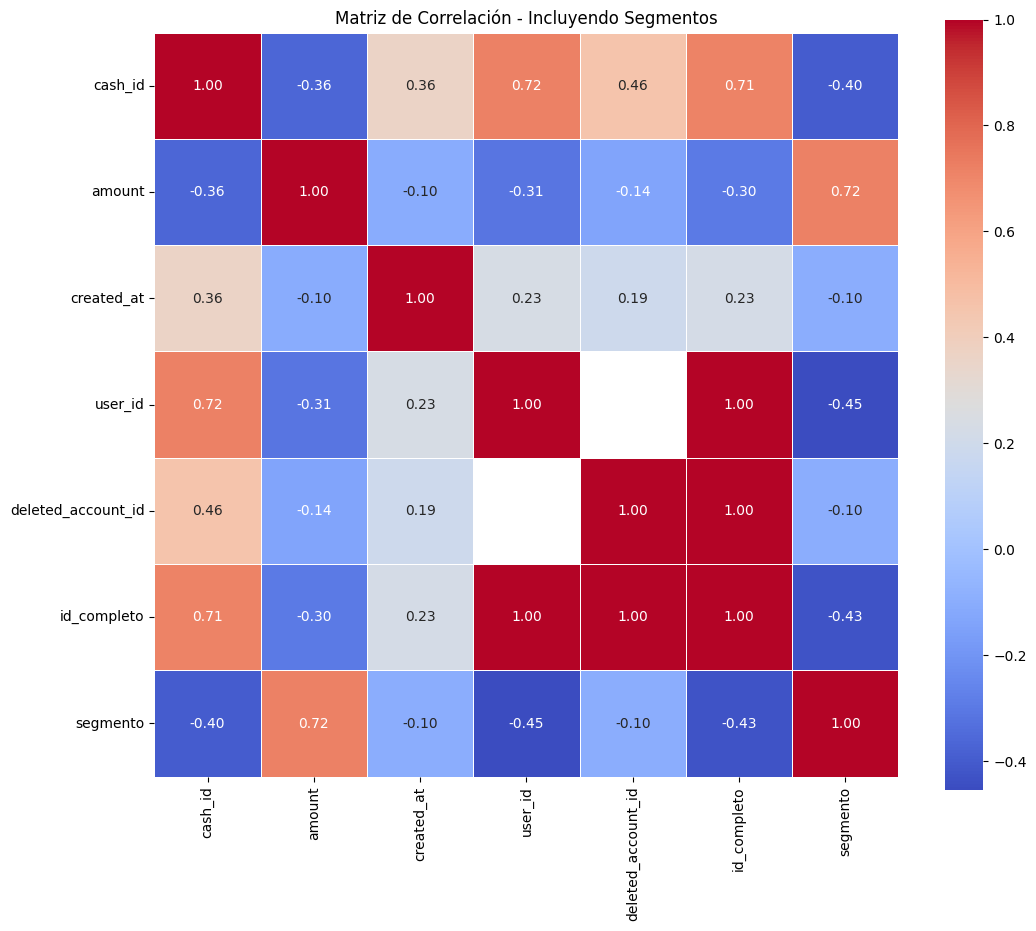


🔹 Variables altamente correlacionadas con otras:


['user_id', 'deleted_account_id', 'id_completo']

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Agregar la columna 'segmento' al DataFrame original
cr["segmento"] = cr["id_completo"].map({user_id: segment for segment, user_ids in grouped_users.items() for user_id in user_ids})

# Convertir la columna 'segmento' en valores numéricos para la correlación
cr["segmento"] = cr["segmento"].map({"Low": 0, "Medium": 1, "High": 2})

# 🔹 Función para limpiar el DataFrame antes del análisis de correlación
def limpiar_dataframe(df):
    df = df.copy()

    # Eliminar columnas irrelevantes
    columnas_a_eliminar = ["id_fe"]
    df = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns], errors='ignore')

    # Convertir columnas de fecha a formato numérico
    d_list = df.select_dtypes(include=['datetime64']).columns
    for date in d_list:
        df[date] = pd.to_datetime(df[date]).dt.strftime('%Y%m%d').astype(float)

    return df

# 🔹 Limpiar el DataFrame
cr_clean = limpiar_dataframe(cr)

# 🔹 Seleccionar solo columnas numéricas para la matriz de correlación
df_corr = cr_clean.select_dtypes(include=['number'])

# 🔹 Calcular la matriz de correlación
matriz_corr = df_corr.corr()

# 🔹 Graficar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_corr, annot=True, cmap="coolwarm", fmt=".2f", square=True, linewidths=0.5)
plt.title("Matriz de Correlación - Incluyendo Segmentos")
plt.show()

# 🔹 Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = [col for col in matriz_corr.columns if any((matriz_corr[col].abs() > threshold) & (matriz_corr.index != col))]

print(f"\n🔹 Variables altamente correlacionadas con otras:")
display(to_drop)
